# PISA 2018 Data - Exploratory Data Analysis

Analyzing PISA 2018 competition data to study:
- Greece's position among participating countries
- Gender gaps across different countries

In [68]:
# Install required packages
!pip install pyreadr pandas numpy matplotlib seaborn plotly

In [69]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadr
from math import pi
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
%matplotlib inline

In [70]:
# Load data
result = pyreadr.read_r('pisa2018.Rdata')
df = result[list(result.keys())[0]]

print(f"Dataset shape: {df.shape}")
print(f"Countries: {df['CNT'].nunique()}")
print(f"Students: {len(df):,}")

Dataset shape: (612004, 14)
Countries: 80
Students: 612,004


In [71]:
# Prepare clean data
df_clean = df.dropna(subset=['MATH', 'READ', 'SCIE'])

# Calculate country-level statistics
country_scores = df_clean.groupby('CNT').agg({
    'MATH': 'mean',
    'READ': 'mean',
    'SCIE': 'mean',
    'CNTSTUID': 'count'
}).round(2)

country_scores.columns = ['Math', 'Reading', 'Science', 'N_Students']
country_scores['Overall'] = country_scores[['Math', 'Reading', 'Science']].mean(axis=1).round(2)
country_scores = country_scores.sort_values('Overall', ascending=False)

# Calculate gender gaps
gender_gap = df_clean.groupby('CNT').apply(
    lambda x: pd.Series({
        'Math_Gap': x[x['ST004D01T'] == 'Male']['MATH'].mean() - x[x['ST004D01T'] == 'Female']['MATH'].mean(),
        'Reading_Gap': x[x['ST004D01T'] == 'Male']['READ'].mean() - x[x['ST004D01T'] == 'Female']['READ'].mean(),
        'Science_Gap': x[x['ST004D01T'] == 'Male']['SCIE'].mean() - x[x['ST004D01T'] == 'Female']['SCIE'].mean()
    })
).round(2)

print(f"\nData prepared: {len(df_clean):,} students, {len(country_scores)} countries")
print(f"Greece rank: {(country_scores['Overall'] > country_scores.loc['Greece', 'Overall']).sum() + 1}/{len(country_scores)}")


Data prepared: 606,627 students, 80 countries
Greece rank: 46/80


## Visualizations

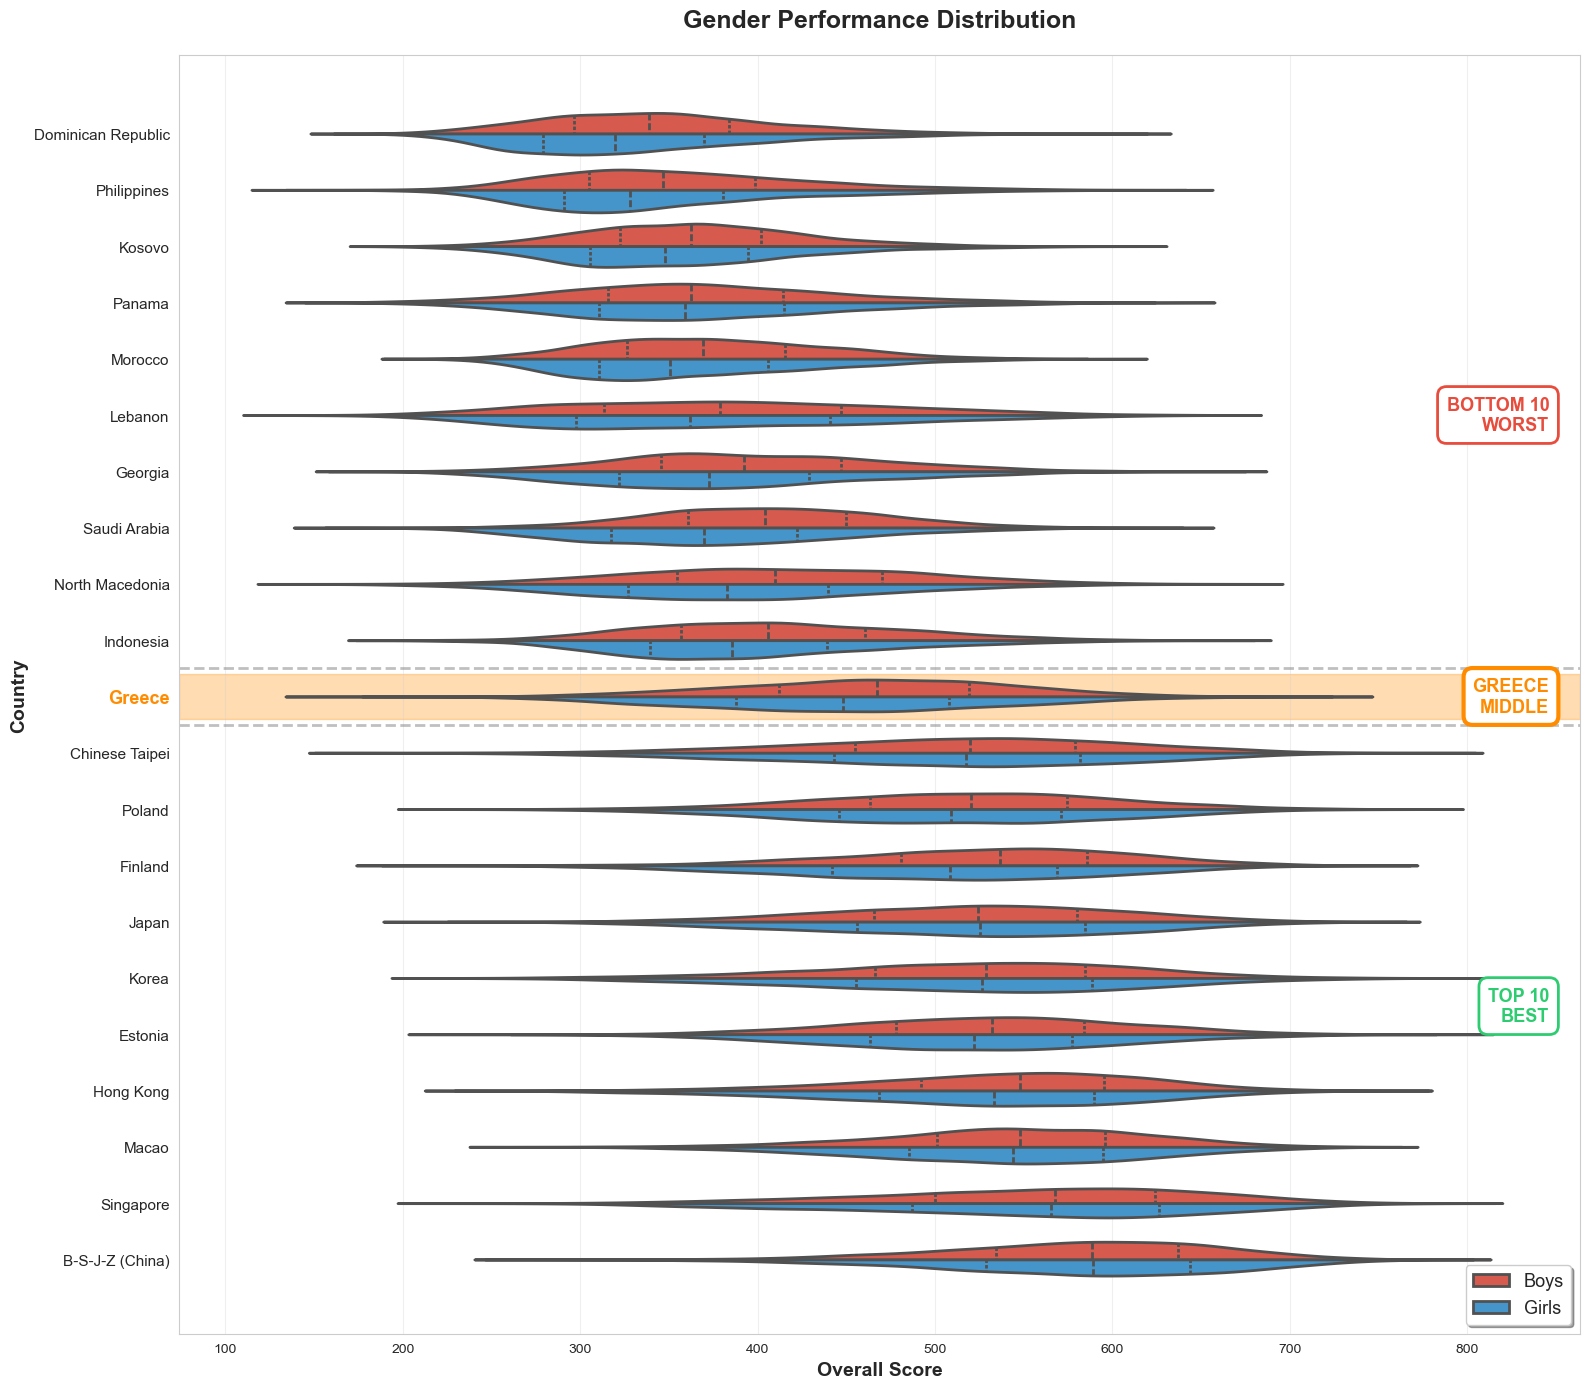

In [72]:
# Plot 1: Horizontal Violin Plot - Gender Distribution by Country
fig, ax = plt.subplots(figsize=(16, 14))

# Get countries - Top 10, Greece (middle), Bottom 10
top10 = country_scores.nlargest(10, 'Overall').index.tolist()
bottom10 = country_scores.nsmallest(10, 'Overall').index.tolist()
greece = ['Greece'] if 'Greece' not in top10 + bottom10 else []
selected_countries = top10 + greece + bottom10

# Filter and prepare data
plot_data = df_clean[df_clean['CNT'].isin(selected_countries)].copy()
plot_data['Overall'] = plot_data[['MATH', 'READ', 'SCIE']].mean(axis=1)

# Order countries by performance (top to bottom)
country_order = country_scores.loc[country_scores.index.isin(selected_countries)].sort_values('Overall', ascending=True).index.tolist()
plot_data['CNT'] = pd.Categorical(plot_data['CNT'], categories=country_order, ordered=True)

# Create split violin (horizontal)
sns.violinplot(data=plot_data, y='CNT', x='Overall', hue='ST004D01T', ax=ax,
               palette={'Male': '#3498db', 'Female': '#e74c3c'}, 
               split=True, linewidth=2, saturation=0.8, inner='quartile', orient='h')

ax.set_ylabel('Country', fontsize=14, fontweight='bold')
ax.set_xlabel('Overall Score', fontsize=14, fontweight='bold')
ax.set_title('Gender Performance Distribution', fontsize=18, fontweight='bold', pad=20)
ax.tick_params(axis='y', labelsize=11)
ax.grid(axis='x', alpha=0.3)

# Highlight Greece in orange/gold
if 'Greece' in country_order:
    greece_pos = country_order.index('Greece')
    # Background highlight
    ax.axhspan(greece_pos - 0.4, greece_pos + 0.4, color='#FF8C00', alpha=0.3, zorder=0)
    # Country label in orange
    yticks = ax.get_yticklabels()
    yticks[greece_pos].set_color('#FF8C00')
    yticks[greece_pos].set_fontweight('bold')
    yticks[greece_pos].set_fontsize(13)

# Add section labels
if greece:
    top_section_middle = (len(country_order) - len(bottom10) - 1 + len(country_order)) / 2
    bottom_section_middle = len(bottom10) / 2
    greece_pos = country_order.index('Greece')
    
    ax.text(ax.get_xlim()[1] * 0.98, top_section_middle, 'TOP 10\nBEST', rotation=0,
            va='center', ha='right', fontsize=13, fontweight='bold', color='#2ecc71',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='#2ecc71', linewidth=2))
    
    ax.text(ax.get_xlim()[1] * 0.98, greece_pos, 'GREECE\nMIDDLE', rotation=0,
            va='center', ha='right', fontsize=13, fontweight='bold', color='#FF8C00',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='#FF8C00', linewidth=3))
    
    ax.text(ax.get_xlim()[1] * 0.98, bottom_section_middle, 'BOTTOM 10\nWORST', rotation=0,
            va='center', ha='right', fontsize=13, fontweight='bold', color='#e74c3c',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='#e74c3c', linewidth=2))
    
    # Separator lines
    ax.axhline(y=len(bottom10) - 0.5, color='gray', linestyle='--', linewidth=2, alpha=0.5)
    ax.axhline(y=len(bottom10) + 0.5, color='gray', linestyle='--', linewidth=2, alpha=0.5)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Boys', 'Girls'], fontsize=13, loc='lower right', frameon=True, shadow=True)

plt.tight_layout()
plt.savefig('EDA_plots/plot_01_violin_gender_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

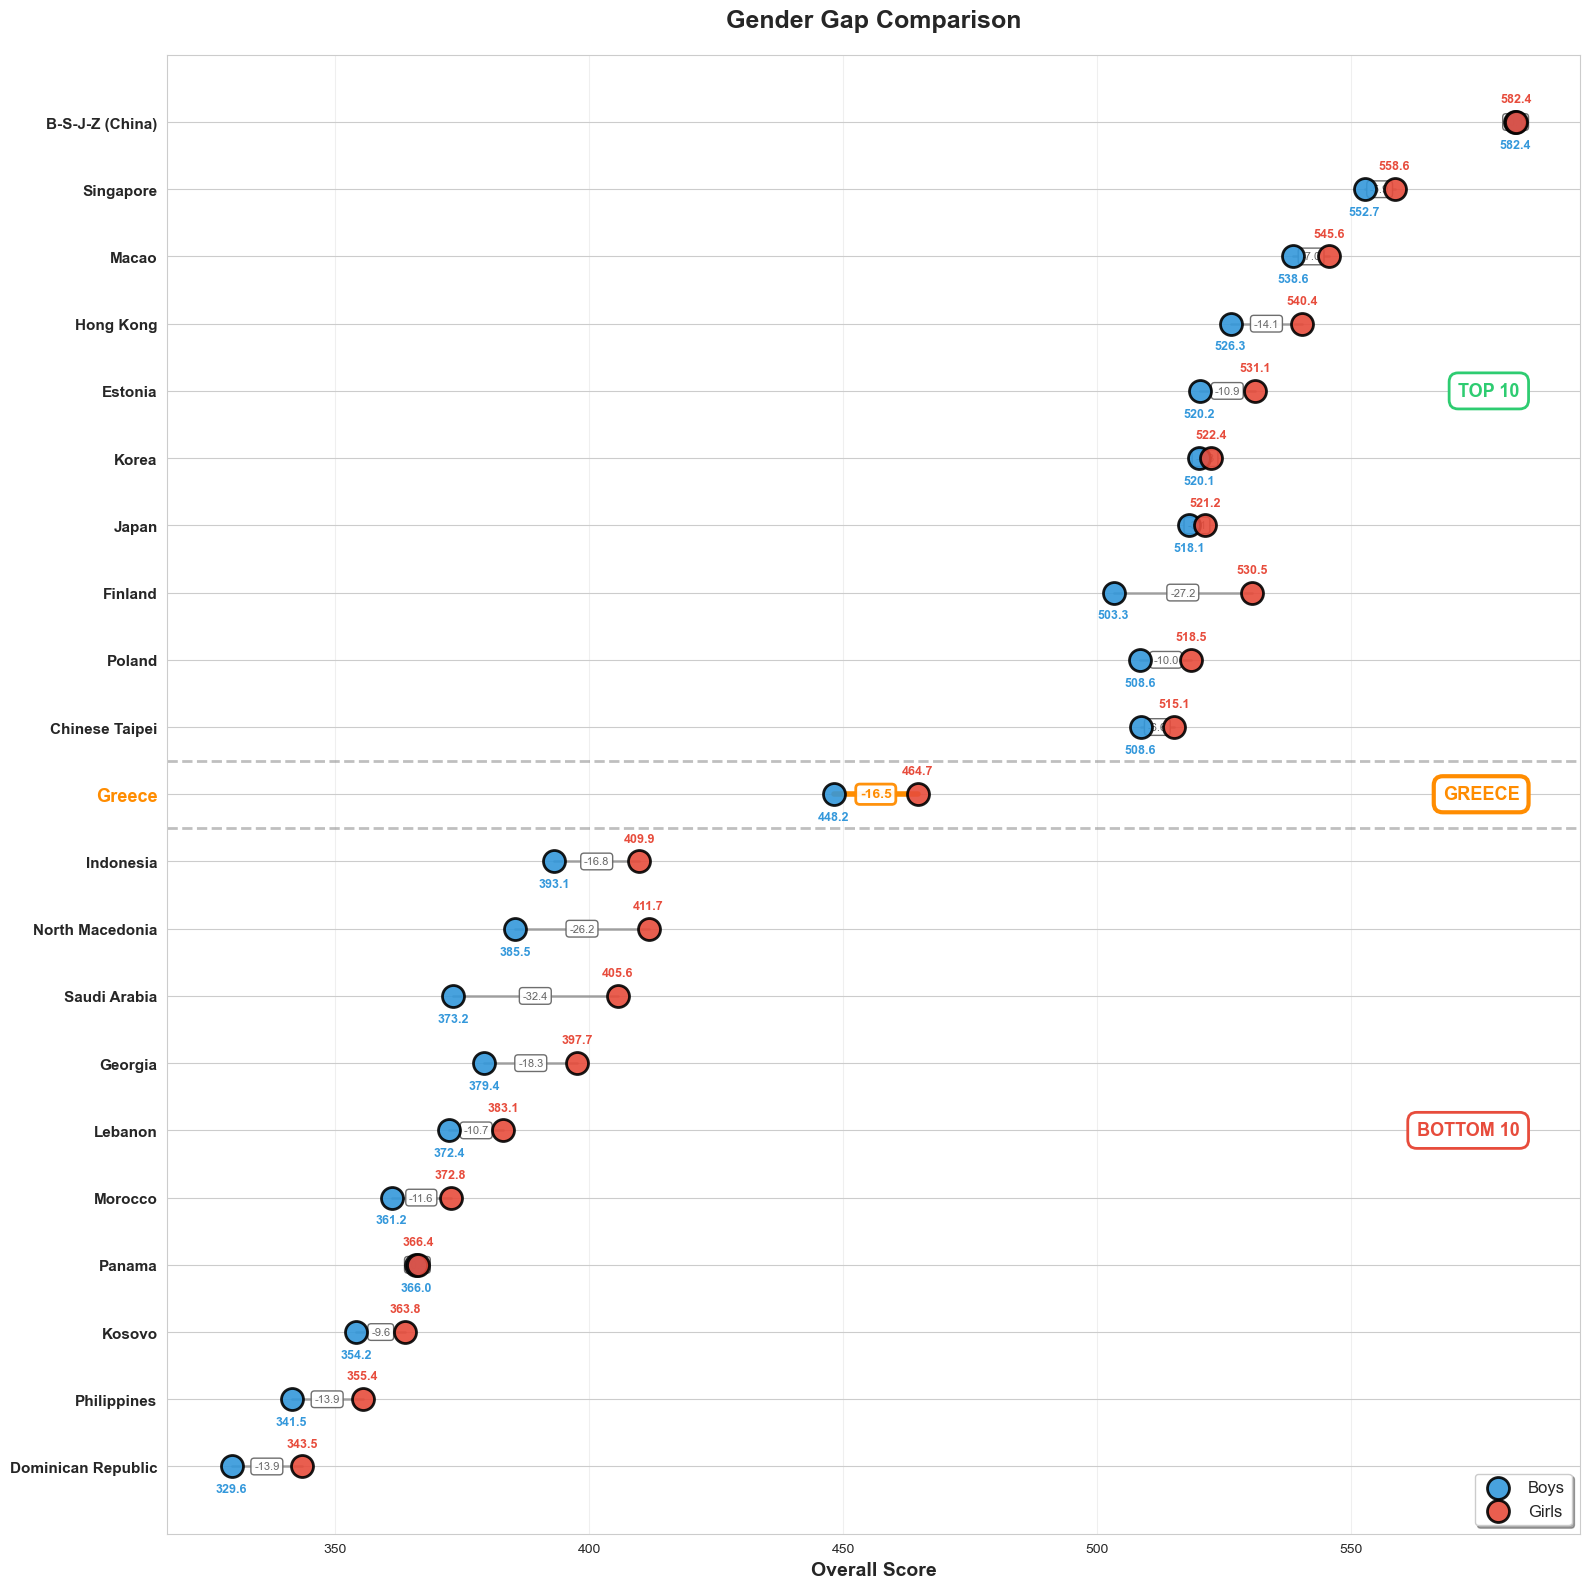

In [73]:
# Plot 2: Dumbbell Chart - Boys vs Girls with Scores
fig, ax = plt.subplots(figsize=(16, 16))

# Get countries - Top 10, Greece, Bottom 10
top10 = country_scores.nlargest(10, 'Overall').index.tolist()
bottom10 = country_scores.nsmallest(10, 'Overall').index.tolist()
greece = ['Greece'] if 'Greece' not in top10 + bottom10 else []
selected_countries = top10 + greece + bottom10

# Calculate gender scores for each country
gender_scores_list = []
for country in selected_countries:
    country_data = df_clean[df_clean['CNT'] == country]
    boys_score = country_data[country_data['ST004D01T'] == 'Male'][['MATH', 'READ', 'SCIE']].mean().mean()
    girls_score = country_data[country_data['ST004D01T'] == 'Female'][['MATH', 'READ', 'SCIE']].mean().mean()
    
    gender_scores_list.append({
        'Country': country,
        'Boys': boys_score,
        'Girls': girls_score,
        'Gap': boys_score - girls_score
    })

gender_df = pd.DataFrame(gender_scores_list)
gender_df['Overall'] = (gender_df['Boys'] + gender_df['Girls']) / 2
gender_df = gender_df.sort_values('Overall', ascending=True)

# Plot
y_pos = range(len(gender_df))

for i, row in gender_df.iterrows():
    y = list(gender_df.index).index(i)
    
    # Color for Greece
    line_color = '#FF8C00' if row['Country'] == 'Greece' else 'gray'
    line_width = 4 if row['Country'] == 'Greece' else 2
    line_alpha = 1 if row['Country'] == 'Greece' else 0.6
    
    # Dumbbell line
    ax.plot([row['Girls'], row['Boys']], [y, y], 
            color=line_color, linewidth=line_width, alpha=line_alpha, zorder=2 if row['Country'] == 'Greece' else 1)
    
    # Determine who scored higher for label positioning
    boys_higher = row['Boys'] > row['Girls']
    
    # Boys dot (blue)
    ax.scatter([row['Boys']], [y], color='#3498db', s=250, 
               alpha=0.9, edgecolors='black', linewidth=2, zorder=5, label='Boys' if i == 0 else '')
    
    # Girls dot (red)
    ax.scatter([row['Girls']], [y], color='#e74c3c', s=250, 
               alpha=0.9, edgecolors='black', linewidth=2, zorder=5, label='Girls' if i == 0 else '')
    
    # Add Boys score - position based on who's higher
    if boys_higher:
        ax.text(row['Boys'], y + 0.25, f"{row['Boys']:.1f}", ha='center', va='bottom',
                fontsize=9, fontweight='bold', color='#3498db')
    else:
        ax.text(row['Boys'], y - 0.25, f"{row['Boys']:.1f}", ha='center', va='top',
                fontsize=9, fontweight='bold', color='#3498db')
    
    # Add Girls score - opposite position
    if boys_higher:
        ax.text(row['Girls'], y - 0.25, f"{row['Girls']:.1f}", ha='center', va='top',
                fontsize=9, fontweight='bold', color='#e74c3c')
    else:
        ax.text(row['Girls'], y + 0.25, f"{row['Girls']:.1f}", ha='center', va='bottom',
                fontsize=9, fontweight='bold', color='#e74c3c')
    
    # Add gap value on the line
    mid_x = (row['Boys'] + row['Girls']) / 2
    gap_text = f"{row['Gap']:+.1f}"
    gap_color = '#FF8C00' if row['Country'] == 'Greece' else '#666'
    fontweight = 'bold' if row['Country'] == 'Greece' else 'normal'
    fontsize = 10 if row['Country'] == 'Greece' else 8
    
    ax.text(mid_x, y, gap_text, ha='center', va='center', 
            fontsize=fontsize, fontweight=fontweight, color=gap_color,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.95, 
                     edgecolor=gap_color, linewidth=2 if row['Country'] == 'Greece' else 1))

# Labels
ax.set_yticks(y_pos)
yticklabels = []
for country in gender_df['Country']:
    yticklabels.append(country)
ax.set_yticklabels(yticklabels, fontsize=11, fontweight='bold')

# Color Greece label
ytick_labels = ax.get_yticklabels()
for i, label in enumerate(ytick_labels):
    if label.get_text() == 'Greece':
        label.set_color('#FF8C00')
        label.set_fontsize(13)

ax.set_xlabel('Overall Score', fontsize=14, fontweight='bold')
ax.set_title('Gender Gap Comparison', fontsize=18, fontweight='bold', pad=20)

# Add section separators and labels
if greece:
    separator1 = len(bottom10) - 0.5
    separator2 = len(bottom10) + 0.5
    
    ax.axhline(y=separator1, color='gray', linestyle='--', linewidth=2, alpha=0.5)
    ax.axhline(y=separator2, color='gray', linestyle='--', linewidth=2, alpha=0.5)
    
    # Section labels
    ax.text(ax.get_xlim()[1] * 0.98, len(bottom10)/2, 'BOTTOM 10', rotation=0, 
            va='center', ha='right', fontsize=13, fontweight='bold', color='#e74c3c',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='#e74c3c', linewidth=2))
    
    greece_pos = len(bottom10)
    ax.text(ax.get_xlim()[1] * 0.98, greece_pos, 'GREECE', rotation=0,
            va='center', ha='right', fontsize=13, fontweight='bold', color='#FF8C00',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='#FF8C00', linewidth=3))
    
    top_middle = len(bottom10) + 1 + len(top10)/2
    ax.text(ax.get_xlim()[1] * 0.98, top_middle, 'TOP 10', rotation=0,
            va='center', ha='right', fontsize=13, fontweight='bold', color='#2ecc71',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='#2ecc71', linewidth=2))

ax.grid(axis='x', alpha=0.3)
ax.legend(fontsize=12, loc='lower right', frameon=True, shadow=True)

plt.tight_layout()
plt.savefig('EDA_plots/plot_02_dumbbell_gender_gap.png', dpi=300, bbox_inches='tight')
plt.show()

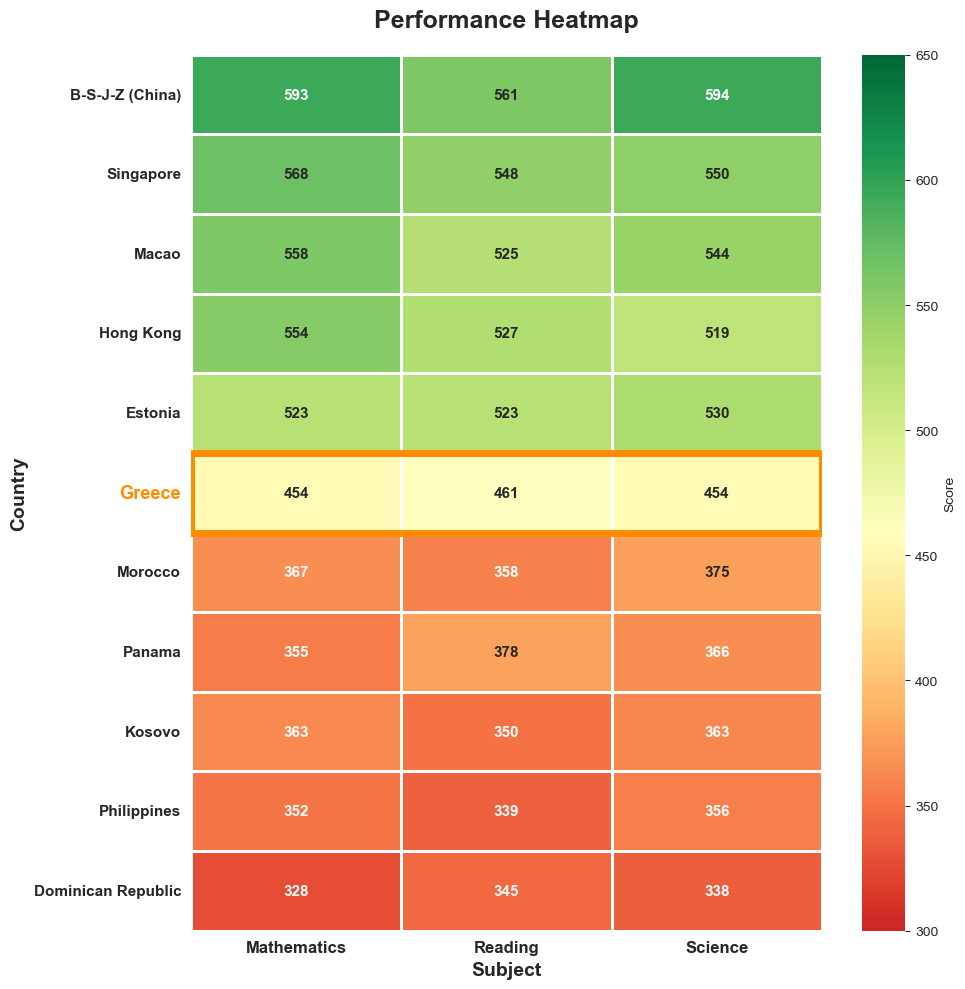

In [74]:
# Plot 3: Heatmap - Top 5 + Greece + Bottom 5
fig, ax = plt.subplots(figsize=(10, 10))

# Get countries
top5 = country_scores.nlargest(5, 'Overall').index.tolist()
bottom5 = country_scores.nsmallest(5, 'Overall').index.tolist()
greece = ['Greece'] if 'Greece' not in top5 + bottom5 else []
selected = top5 + greece + bottom5

# Prepare data for heatmap
heatmap_data = country_scores.loc[selected, ['Math', 'Reading', 'Science']]
# Sort: top 5 (descending), greece, bottom 5 (descending)
top5_sorted = country_scores.loc[top5].sort_values('Overall', ascending=False).index.tolist()
bottom5_sorted = country_scores.loc[bottom5].sort_values('Overall', ascending=False).index.tolist()
ordered = top5_sorted + greece + bottom5_sorted
heatmap_data = heatmap_data.loc[ordered]

# Create heatmap
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='RdYlGn', center=460,
            linewidths=2, linecolor='white', cbar_kws={'label': 'Score'},
            ax=ax, vmin=300, vmax=650, annot_kws={'fontsize': 11, 'fontweight': 'bold'})

# Highlight Greece row
if 'Greece' in heatmap_data.index:
    greece_pos = list(heatmap_data.index).index('Greece')
    ax.add_patch(plt.Rectangle((0, greece_pos), 3, 1, fill=False, 
                               edgecolor='#FF8C00', linewidth=5, zorder=10))

# Add section separators
if greece:
    ax.axhline(y=len(top5), color='black', linestyle='--', linewidth=2.5, alpha=0.7)
    ax.axhline(y=len(top5) + 1, color='black', linestyle='--', linewidth=2.5, alpha=0.7)

# Style
ax.set_xlabel('Subject', fontsize=14, fontweight='bold')
ax.set_ylabel('Country', fontsize=14, fontweight='bold')
ax.set_title('Performance Heatmap', fontsize=18, fontweight='bold', pad=20)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=11, fontweight='bold', rotation=0)
ax.set_xticklabels(['Mathematics', 'Reading', 'Science'], fontsize=12, fontweight='bold', rotation=0)

# Color Greece label
ytick_labels = ax.get_yticklabels()
for label in ytick_labels:
    if label.get_text() == 'Greece':
        label.set_color('#FF8C00')
        label.set_fontsize(13)

plt.tight_layout()
plt.savefig('EDA_plots/plot_03_heatmap_performance.png', dpi=300, bbox_inches='tight')
plt.show()

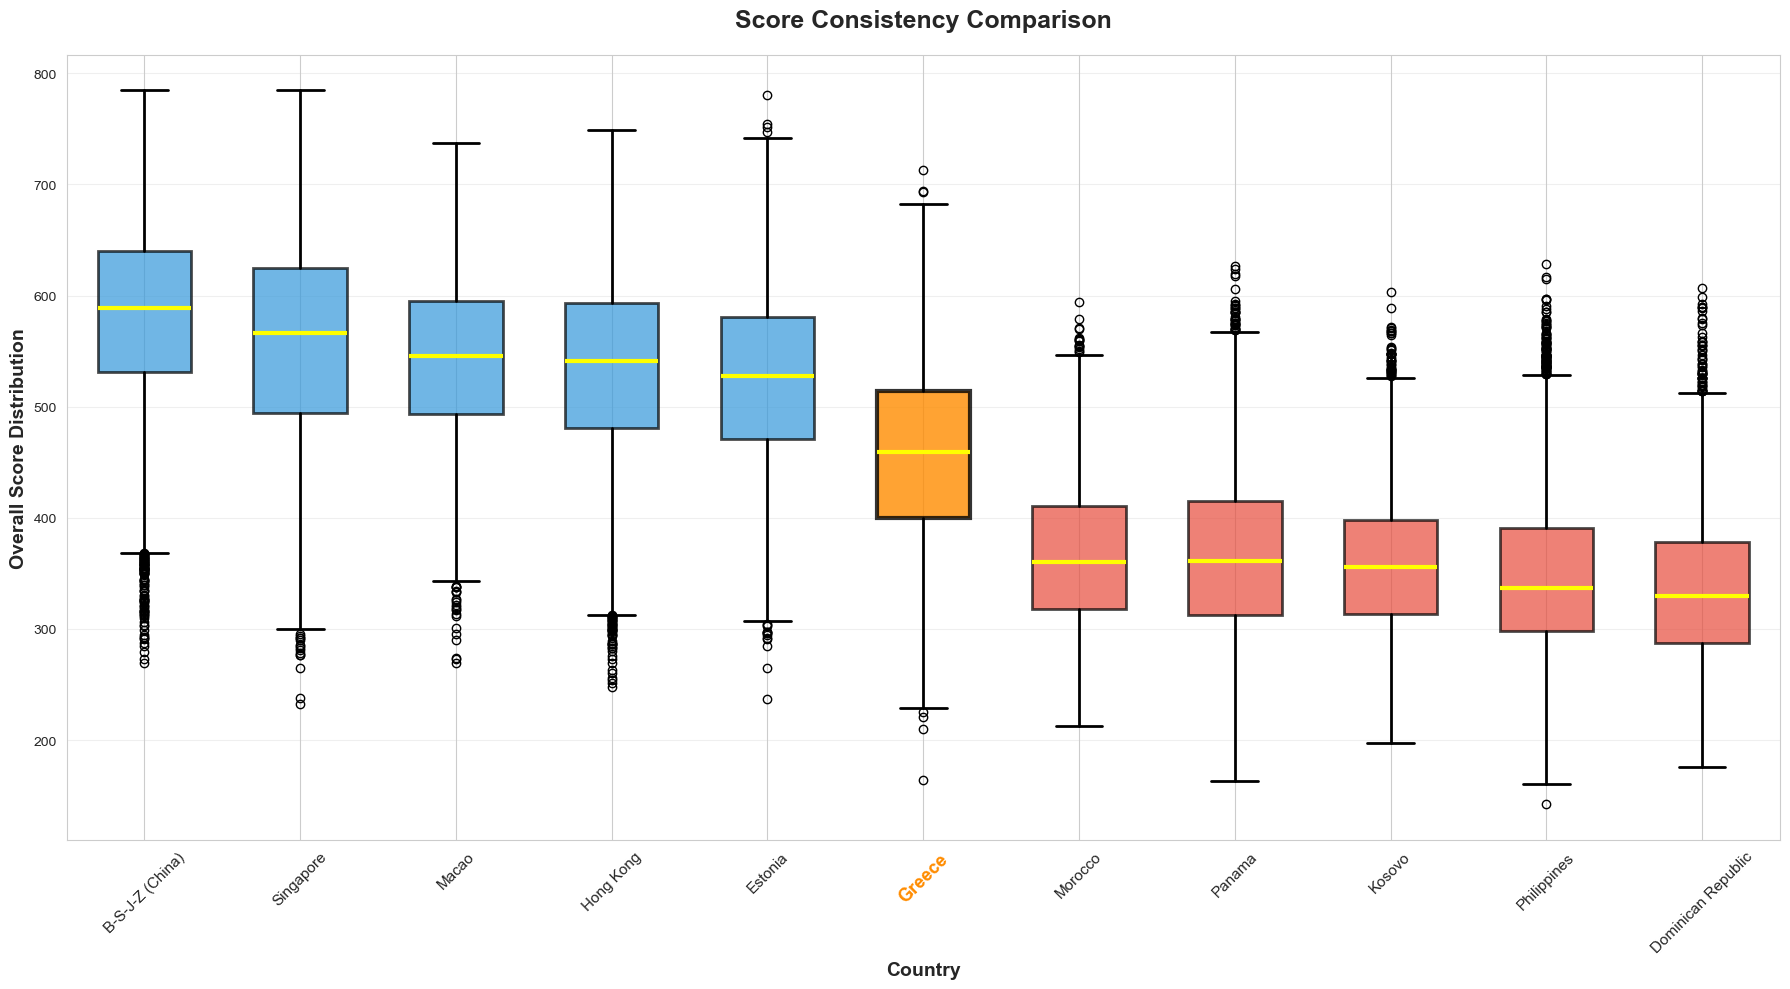

In [75]:
# Plot 4: Box Plot - Score Variability (Top 5 + Greece + Bottom 5)
fig, ax = plt.subplots(figsize=(18, 10))

# Get countries
top5 = country_scores.nlargest(5, 'Overall').index.tolist()
bottom5 = country_scores.nsmallest(5, 'Overall').index.tolist()
greece = ['Greece'] if 'Greece' not in top5 + bottom5 else []
selected = top5 + greece + bottom5

# Prepare data
plot_data = df_clean[df_clean['CNT'].isin(selected)].copy()
plot_data['Overall'] = plot_data[['MATH', 'READ', 'SCIE']].mean(axis=1)

# Order by performance
country_order = country_scores.loc[selected].sort_values('Overall', ascending=False).index.tolist()
plot_data['CNT'] = pd.Categorical(plot_data['CNT'], categories=country_order, ordered=True)

# Create box plot
bp = ax.boxplot([plot_data[plot_data['CNT'] == country]['Overall'].values for country in country_order],
                 labels=country_order, patch_artist=True, widths=0.6,
                 boxprops=dict(linewidth=2), whiskerprops=dict(linewidth=2),
                 capprops=dict(linewidth=2), medianprops=dict(linewidth=3, color='yellow'))

# Color boxes
for i, (patch, country) in enumerate(zip(bp['boxes'], country_order)):
    if country == 'Greece':
        patch.set_facecolor('#FF8C00')
        patch.set_alpha(0.8)
        patch.set_edgecolor('black')
        patch.set_linewidth(3)
    elif country in top5:
        patch.set_facecolor('#3498db')  # Blue for top
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')
    else:
        patch.set_facecolor('#e74c3c')  # Red for bottom
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')

ax.set_xlabel('Country', fontsize=14, fontweight='bold')
ax.set_ylabel('Overall Score Distribution', fontsize=14, fontweight='bold')
ax.set_title('Score Consistency Comparison', fontsize=18, fontweight='bold', pad=20)
ax.tick_params(axis='x', rotation=45, labelsize=11)
ax.grid(axis='y', alpha=0.3)

# Highlight Greece label
xtick_labels = ax.get_xticklabels()
for label in xtick_labels:
    if label.get_text() == 'Greece':
        label.set_color('#FF8C00')
        label.set_fontweight('bold')
        label.set_fontsize(13)

plt.tight_layout()
plt.savefig('EDA_plots/plot_04_boxplot_consistency.png', dpi=300, bbox_inches='tight')
plt.show()

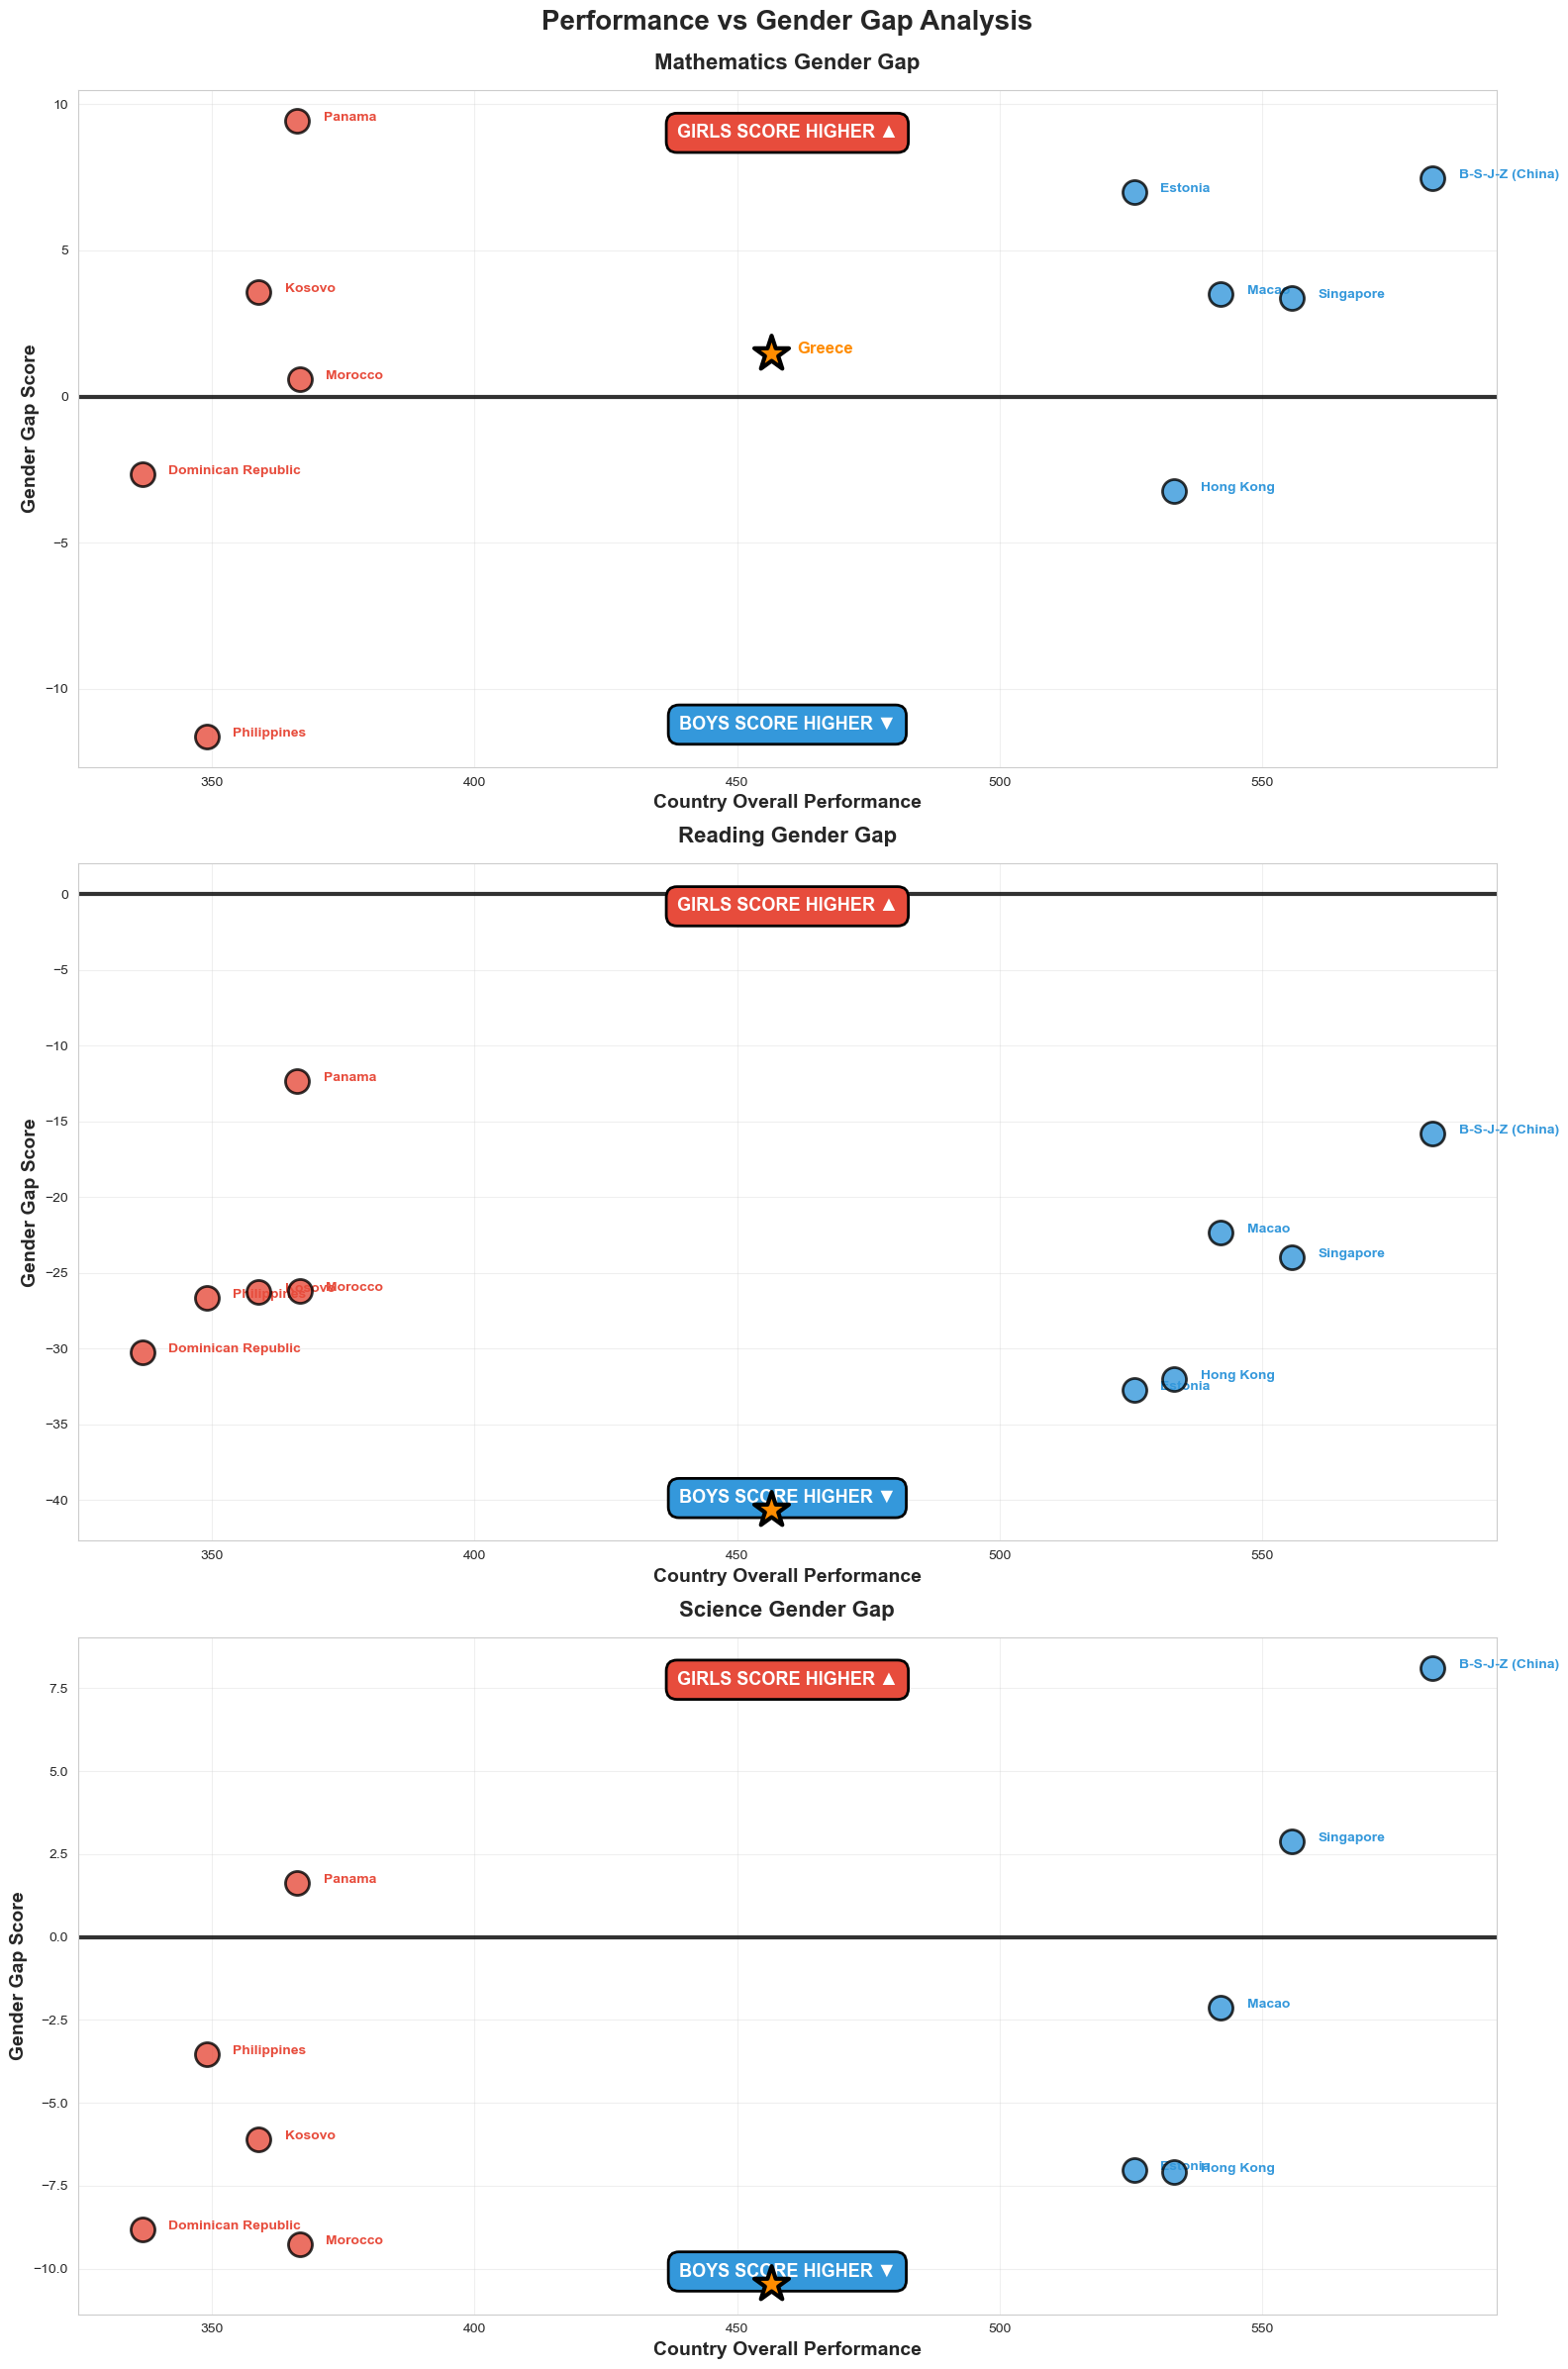

In [76]:
# Plot 5: Scatter - Performance vs Gender Gap (Top 5 + Greece + Bottom 5)
fig, axes = plt.subplots(3, 1, figsize=(16, 24))

subjects = [('Math_Gap', 'Mathematics'), ('Reading_Gap', 'Reading'), ('Science_Gap', 'Science')]

# Get countries to display
top5 = country_scores.nlargest(5, 'Overall').index.tolist()
bottom5 = country_scores.nsmallest(5, 'Overall').index.tolist()
greece = ['Greece'] if 'Greece' not in top5 + bottom5 else []
selected_countries = top5 + greece + bottom5

for ax, (gap_col, title) in zip(axes, subjects):
    # Plot selected countries only
    for country in selected_countries:
        overall_score = country_scores.loc[country, 'Overall']
        gap = gender_gap.loc[country, gap_col]
        
        if country == 'Greece':
            ax.scatter(overall_score, gap, s=700, color='#FF8C00', marker='*',
                       edgecolors='black', linewidth=3, zorder=10)
            ax.text(overall_score + 5, gap, country, fontsize=12, fontweight='bold', color='#FF8C00')
        elif country in top5:
            # Top 5 - blue
            ax.scatter(overall_score, gap, s=300, color='#3498db', alpha=0.8,
                       edgecolors='black', linewidth=2, zorder=5)
            ax.text(overall_score + 5, gap, country, fontsize=10, color='#3498db', fontweight='bold')
        else:
            # Bottom 5 - red
            ax.scatter(overall_score, gap, s=300, color='#e74c3c', alpha=0.8,
                       edgecolors='black', linewidth=2, zorder=5)
            ax.text(overall_score + 5, gap, country, fontsize=10, color='#e74c3c', fontweight='bold')
    
    # Zero line (equal performance)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=3, alpha=0.8)
    
    # Clear region labels
    ax.text(0.5, 0.95, 'GIRLS SCORE HIGHER ▲', transform=ax.transAxes,
            fontsize=13, va='top', ha='center', color='white', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.6', facecolor='#e74c3c', edgecolor='black', linewidth=2))
    
    ax.text(0.5, 0.05, 'BOYS SCORE HIGHER ▼', transform=ax.transAxes,
            fontsize=13, va='bottom', ha='center', color='white', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.6', facecolor='#3498db', edgecolor='black', linewidth=2))
    
    ax.set_xlabel('Country Overall Performance', fontsize=14, fontweight='bold')
    ax.set_ylabel('Gender Gap Score', fontsize=14, fontweight='bold')
    ax.set_title(f'{title} Gender Gap', fontsize=16, fontweight='bold', pad=15)
    ax.grid(alpha=0.3)

fig.suptitle('Performance vs Gender Gap Analysis', 
             fontsize=20, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('EDA_plots/plot_05_scatter_performance_vs_gap.png', dpi=300, bbox_inches='tight')
plt.show()

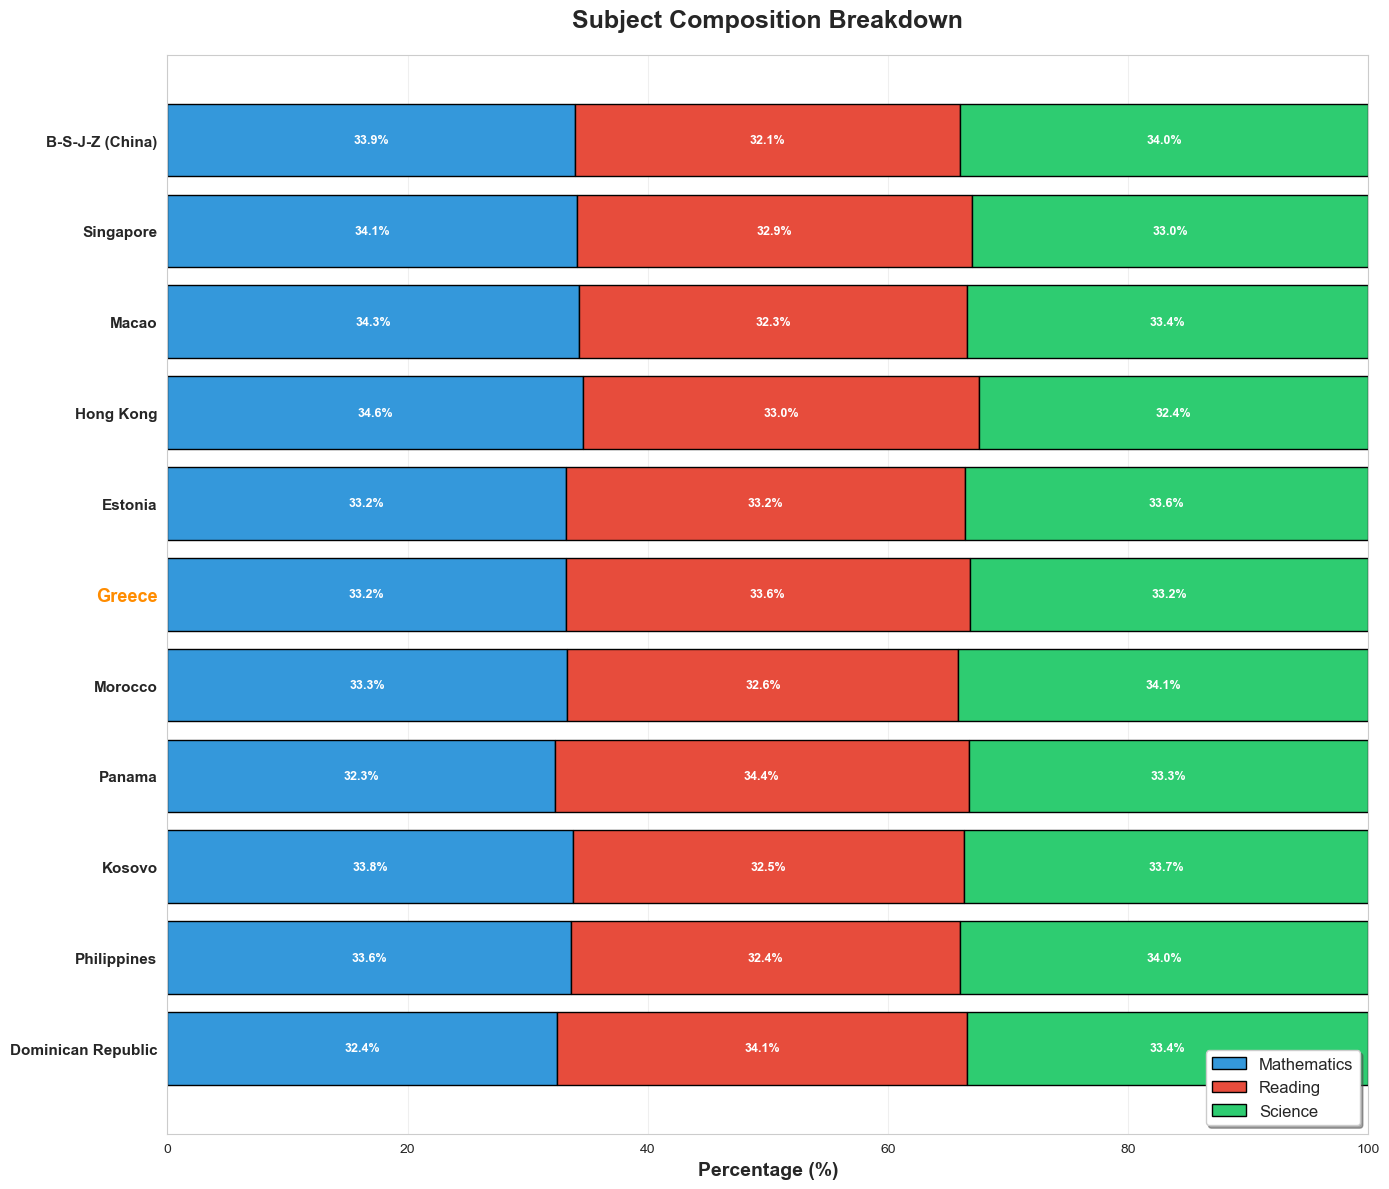

In [77]:
# Plot 6: Percentage Stacked Bar - Subject Composition
fig, ax = plt.subplots(figsize=(14, 12))

# Get countries
top5 = country_scores.nlargest(5, 'Overall').index.tolist()
bottom5 = country_scores.nsmallest(5, 'Overall').index.tolist()
greece = ['Greece'] if 'Greece' not in top5 + bottom5 else []
selected = top5 + greece + bottom5

# Calculate percentages
percentages = []
for country in selected:
    total = country_scores.loc[country, ['Math', 'Reading', 'Science']].sum()
    math_pct = (country_scores.loc[country, 'Math'] / total) * 100
    reading_pct = (country_scores.loc[country, 'Reading'] / total) * 100
    science_pct = (country_scores.loc[country, 'Science'] / total) * 100
    percentages.append({'Country': country, 'Math': math_pct, 'Reading': reading_pct, 'Science': science_pct})

pct_df = pd.DataFrame(percentages)
pct_df = pct_df.set_index('Country')

# Order by performance
ordered = country_scores.loc[selected].sort_values('Overall', ascending=True).index.tolist()
pct_df = pct_df.loc[ordered]

# Create stacked bar
bar_width = 0.8
y_pos = np.arange(len(pct_df))

p1 = ax.barh(y_pos, pct_df['Math'], bar_width, label='Mathematics', color='#3498db', edgecolor='black', linewidth=1)
p2 = ax.barh(y_pos, pct_df['Reading'], bar_width, left=pct_df['Math'], label='Reading', color='#e74c3c', edgecolor='black', linewidth=1)
p3 = ax.barh(y_pos, pct_df['Science'], bar_width, left=pct_df['Math'] + pct_df['Reading'], label='Science', color='#2ecc71', edgecolor='black', linewidth=1)

# Highlight Greece
if 'Greece' in pct_df.index:
    greece_pos = list(pct_df.index).index('Greece')
    ax.axhline(y=greece_pos, color='#FF8C00', linestyle='--', linewidth=4, alpha=0.7, zorder=0)

ax.set_yticks(y_pos)
ax.set_yticklabels(pct_df.index, fontsize=11, fontweight='bold')
ax.set_xlabel('Percentage (%)', fontsize=14, fontweight='bold')
ax.set_title('Subject Composition Breakdown', fontsize=18, fontweight='bold', pad=20)
ax.set_xlim(0, 100)
ax.legend(fontsize=12, loc='lower right', frameon=True, shadow=True)
ax.grid(axis='x', alpha=0.3)

# Color Greece label
ytick_labels = ax.get_yticklabels()
for label in ytick_labels:
    if label.get_text() == 'Greece':
        label.set_color('#FF8C00')
        label.set_fontsize(13)

# Add percentage values on bars
for i, country in enumerate(pct_df.index):
    # Math
    ax.text(pct_df.loc[country, 'Math']/2, i, f"{pct_df.loc[country, 'Math']:.1f}%", 
            ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    # Reading
    ax.text(pct_df.loc[country, 'Math'] + pct_df.loc[country, 'Reading']/2, i, 
            f"{pct_df.loc[country, 'Reading']:.1f}%", 
            ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    # Science
    ax.text(pct_df.loc[country, 'Math'] + pct_df.loc[country, 'Reading'] + pct_df.loc[country, 'Science']/2, i, 
            f"{pct_df.loc[country, 'Science']:.1f}%", 
            ha='center', va='center', fontsize=9, fontweight='bold', color='white')

plt.tight_layout()
plt.savefig('EDA_plots/plot_06_stacked_subject_composition.png', dpi=300, bbox_inches='tight')
plt.show()

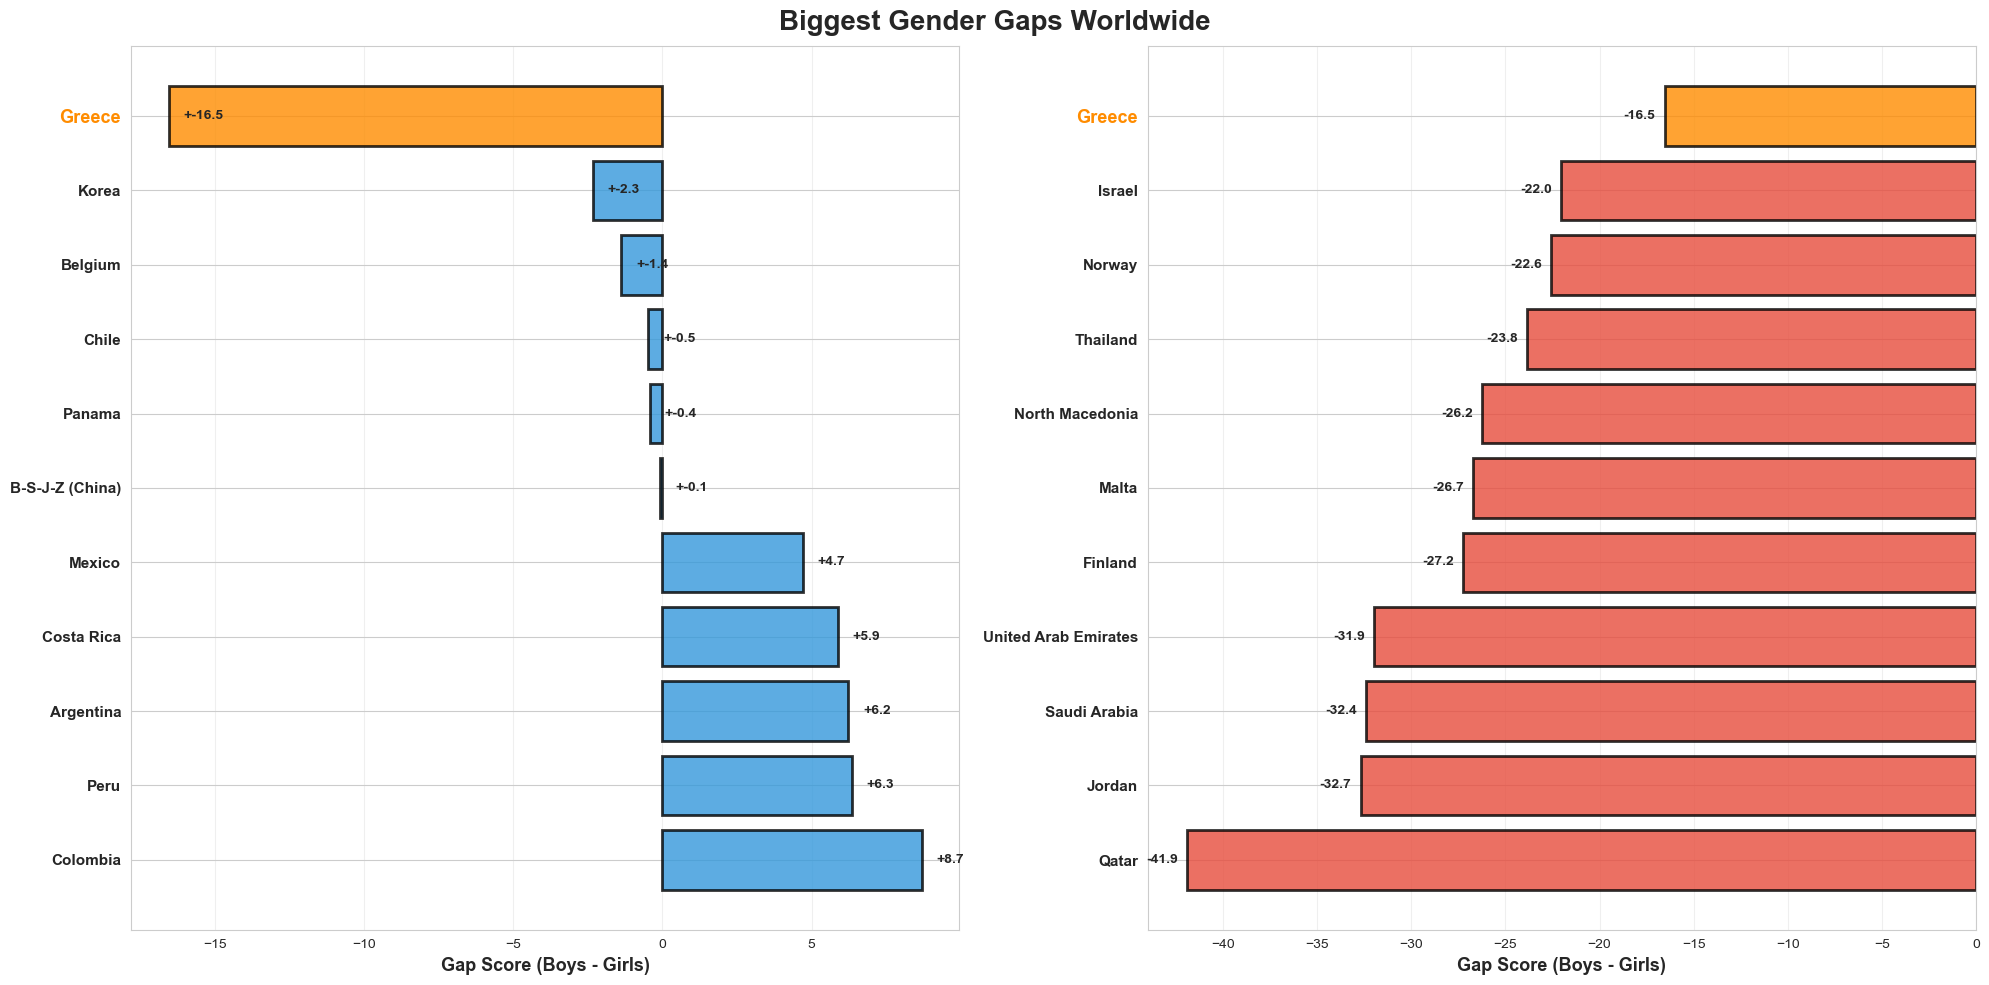

In [78]:
# Plot 7: Gender Gap Extremes - Biggest Gaps (with Greece)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Calculate absolute gap for overall (average of 3 subjects)
gender_gap['Overall_Gap'] = (gender_gap['Math_Gap'] + gender_gap['Reading_Gap'] + gender_gap['Science_Gap']) / 3

# Top 10 where BOYS are most ahead + Greece
boys_ahead = gender_gap.nlargest(10, 'Overall_Gap')[['Overall_Gap']]
if 'Greece' not in boys_ahead.index:
    boys_ahead = pd.concat([boys_ahead, gender_gap.loc[['Greece'], ['Overall_Gap']]])
boys_ahead = boys_ahead.sort_values('Overall_Gap')

# Top 10 where GIRLS are most ahead + Greece
girls_ahead = gender_gap.nsmallest(10, 'Overall_Gap')[['Overall_Gap']]
if 'Greece' not in girls_ahead.index:
    girls_ahead = pd.concat([girls_ahead, gender_gap.loc[['Greece'], ['Overall_Gap']]])
girls_ahead = girls_ahead.sort_values('Overall_Gap', ascending=False)

# LEFT: Boys Ahead
y_pos = np.arange(len(boys_ahead))
colors1 = ['#FF8C00' if country == 'Greece' else '#3498db' for country in boys_ahead.index]
bars1 = axes[0].barh(y_pos, boys_ahead['Overall_Gap'], color=colors1, 
                     edgecolor='black', linewidth=2, alpha=0.8)

axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(boys_ahead.index, fontsize=11, fontweight='bold')
axes[0].set_xlabel('Gap Score (Boys - Girls)', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

for i, (idx, row) in enumerate(boys_ahead.iterrows()):
    axes[0].text(row['Overall_Gap'] + 0.5, i, f"+{row['Overall_Gap']:.1f}", 
                va='center', fontsize=10, fontweight='bold')

# Color Greece label
for label in axes[0].get_yticklabels():
    if label.get_text() == 'Greece':
        label.set_color('#FF8C00')
        label.set_fontsize(13)

# RIGHT: Girls Ahead
y_pos = np.arange(len(girls_ahead))
colors2 = ['#FF8C00' if country == 'Greece' else '#e74c3c' for country in girls_ahead.index]
bars2 = axes[1].barh(y_pos, girls_ahead['Overall_Gap'], color=colors2, 
                     edgecolor='black', linewidth=2, alpha=0.8)

axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(girls_ahead.index, fontsize=11, fontweight='bold')
axes[1].set_xlabel('Gap Score (Boys - Girls)', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

for i, (idx, row) in enumerate(girls_ahead.iterrows()):
    axes[1].text(row['Overall_Gap'] - 0.5, i, f"{row['Overall_Gap']:.1f}", 
                va='center', ha='right', fontsize=10, fontweight='bold')

# Color Greece label
for label in axes[1].get_yticklabels():
    if label.get_text() == 'Greece':
        label.set_color('#FF8C00')
        label.set_fontsize(13)

fig.suptitle('Biggest Gender Gaps Worldwide', fontsize=20, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('EDA_plots/plot_07_gender_gap_extremes.png', dpi=300, bbox_inches='tight')
plt.show()

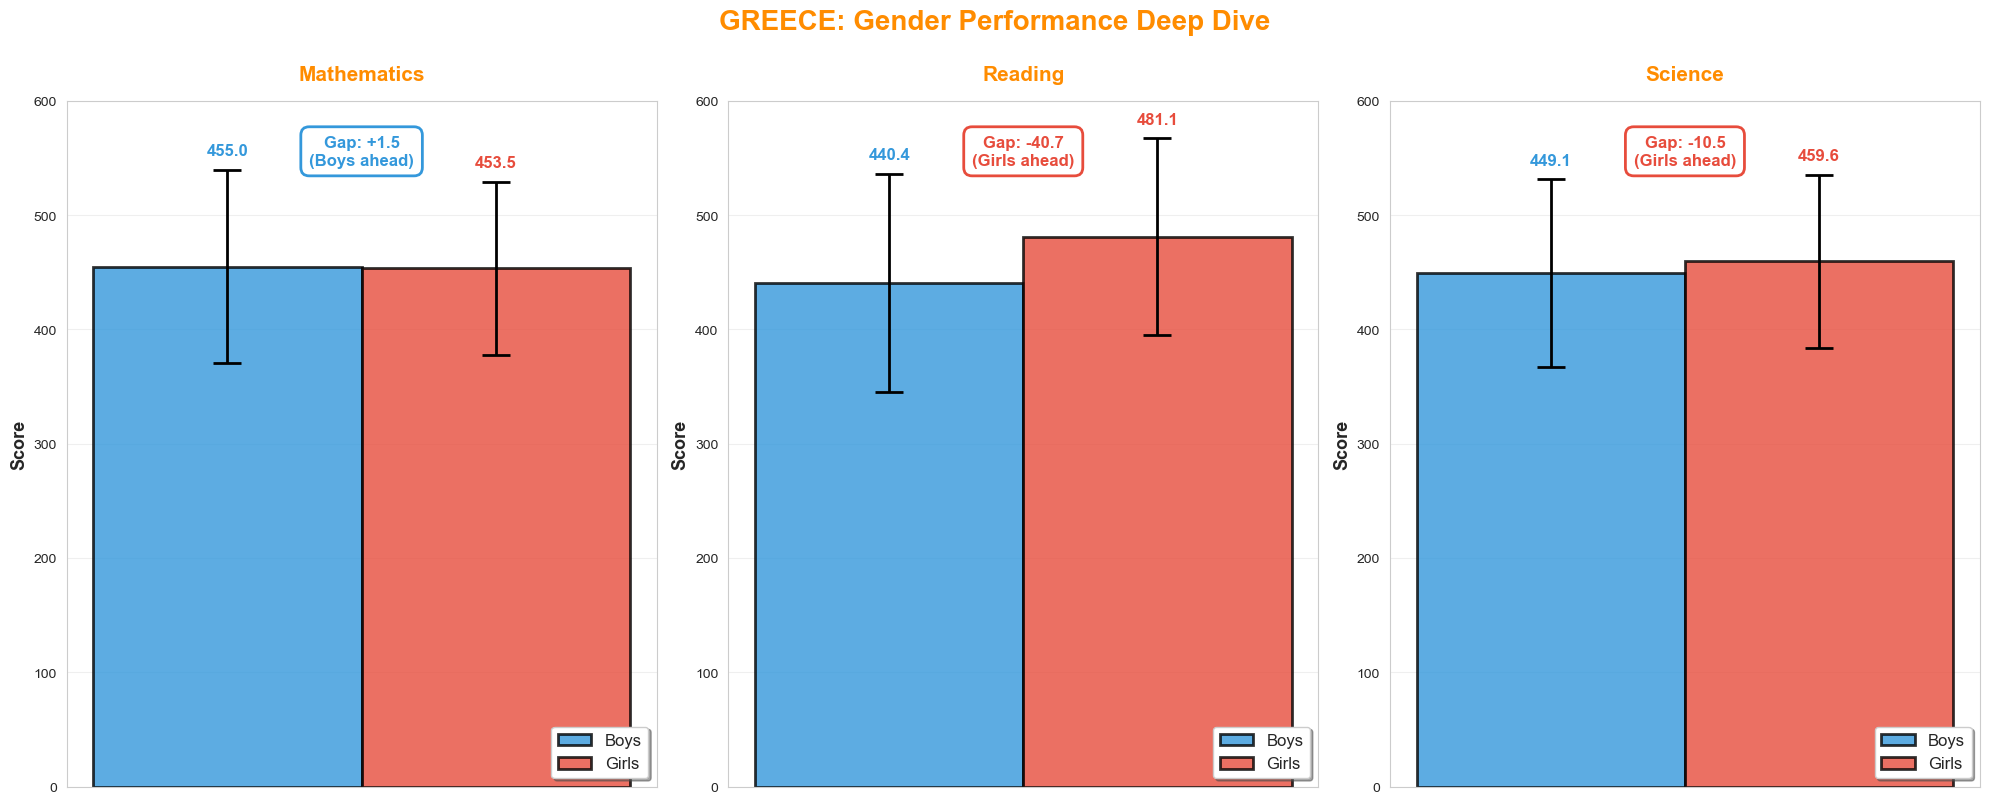

In [79]:
# Plot 8: Greece Deep Dive - Detailed Gender Breakdown
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

greece_data = df_clean[df_clean['CNT'] == 'Greece']
subjects = [('MATH', 'Mathematics'), ('READ', 'Reading'), ('SCIE', 'Science')]

for ax, (col, title) in zip(axes, subjects):
    boys = greece_data[greece_data['ST004D01T'] == 'Male'][col]
    girls = greece_data[greece_data['ST004D01T'] == 'Female'][col]
    
    # Create grouped bar
    x = np.arange(1)
    width = 0.35
    
    bar1 = ax.bar(x - width/2, boys.mean(), width, label='Boys', color='#3498db', 
                  edgecolor='black', linewidth=2, alpha=0.8)
    bar2 = ax.bar(x + width/2, girls.mean(), width, label='Girls', color='#e74c3c', 
                  edgecolor='black', linewidth=2, alpha=0.8)
    
    # Add error bars (std dev)
    ax.errorbar(x - width/2, boys.mean(), yerr=boys.std(), fmt='none', 
                color='black', linewidth=2, capsize=10, capthick=2)
    ax.errorbar(x + width/2, girls.mean(), yerr=girls.std(), fmt='none', 
                color='black', linewidth=2, capsize=10, capthick=2)
    
    # Add values
    ax.text(x - width/2, boys.mean() + boys.std() + 10, f'{boys.mean():.1f}', 
            ha='center', va='bottom', fontsize=12, fontweight='bold', color='#3498db')
    ax.text(x + width/2, girls.mean() + girls.std() + 10, f'{girls.mean():.1f}', 
            ha='center', va='bottom', fontsize=12, fontweight='bold', color='#e74c3c')
    
    # Gap info
    gap = boys.mean() - girls.mean()
    gap_color = '#3498db' if gap > 0 else '#e74c3c'
    gap_text = f"Gap: {gap:+.1f}"
    if gap > 0:
        winner = "Boys ahead"
    else:
        winner = "Girls ahead"
    
    ax.text(0.5, 0.95, f'{gap_text}\n({winner})', transform=ax.transAxes,
            fontsize=12, fontweight='bold', color=gap_color, ha='center', va='top',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor=gap_color, linewidth=2))
    
    ax.set_xticks([])
    ax.set_ylabel('Score', fontsize=13, fontweight='bold')
    ax.set_title(f'{title}', fontsize=15, fontweight='bold', pad=15, color='#FF8C00')
    ax.set_ylim(0, 600)
    ax.legend(fontsize=12, loc='lower right', frameon=True, shadow=True)
    ax.grid(axis='y', alpha=0.3)

fig.suptitle('GREECE: Gender Performance Deep Dive', fontsize=20, fontweight='bold', 
             y=1.00, color='#FF8C00')
plt.tight_layout()
plt.savefig('EDA_plots/plot_08_greece_deep_dive.png', dpi=300, bbox_inches='tight')
plt.show()

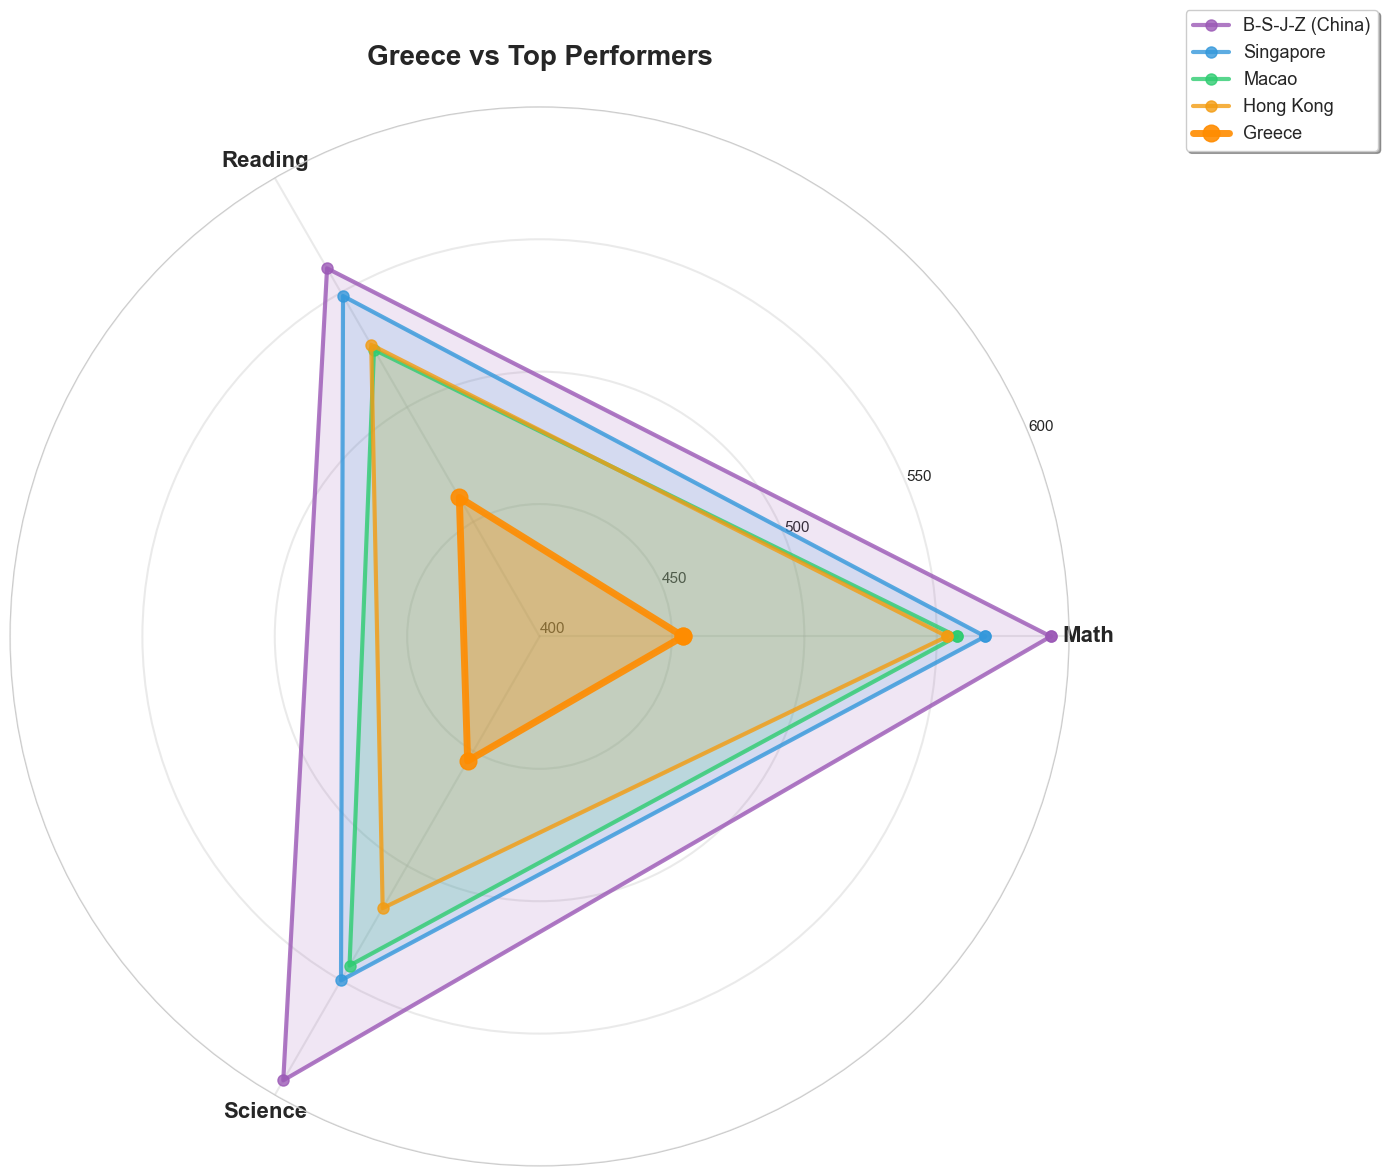

In [80]:
# Plot 9: Radar Chart - Greece vs Top Performers
from math import pi

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='polar')

# Get top 4 performers + Greece
top4 = country_scores.nlargest(4, 'Overall').index.tolist()
countries_to_plot = top4 + ['Greece']
categories = ['Math', 'Reading', 'Science']

# Number of variables
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Colors
colors = ['#9b59b6', '#3498db', '#2ecc71', '#f39c12', '#FF8C00']

# Plot each country
for i, country in enumerate(countries_to_plot):
    values = country_scores.loc[country, categories].values.tolist()
    values += values[:1]
    
    if country == 'Greece':
        linewidth = 5
        alpha = 0.9
        markersize = 12
    else:
        linewidth = 3
        alpha = 0.8
        markersize = 8
    
    ax.plot(angles, values, 'o-', linewidth=linewidth, label=country, 
            color=colors[i], alpha=alpha, markersize=markersize)
    ax.fill(angles, values, alpha=0.15 if country != 'Greece' else 0.3, color=colors[i])

# Customize
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=16, fontweight='bold')
ax.set_ylim(400, 600)
ax.set_title('Greece vs Top Performers', size=20, fontweight='bold', pad=30)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=13, frameon=True, shadow=True)
ax.grid(True, linewidth=1.5, alpha=0.4)

# Add radial grid labels
ax.set_yticks([400, 450, 500, 550, 600])
ax.set_yticklabels(['400', '450', '500', '550', '600'], fontsize=11)

plt.tight_layout()
plt.savefig('EDA_plots/plot_09_radar_greece_vs_top.png', dpi=300, bbox_inches='tight')
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


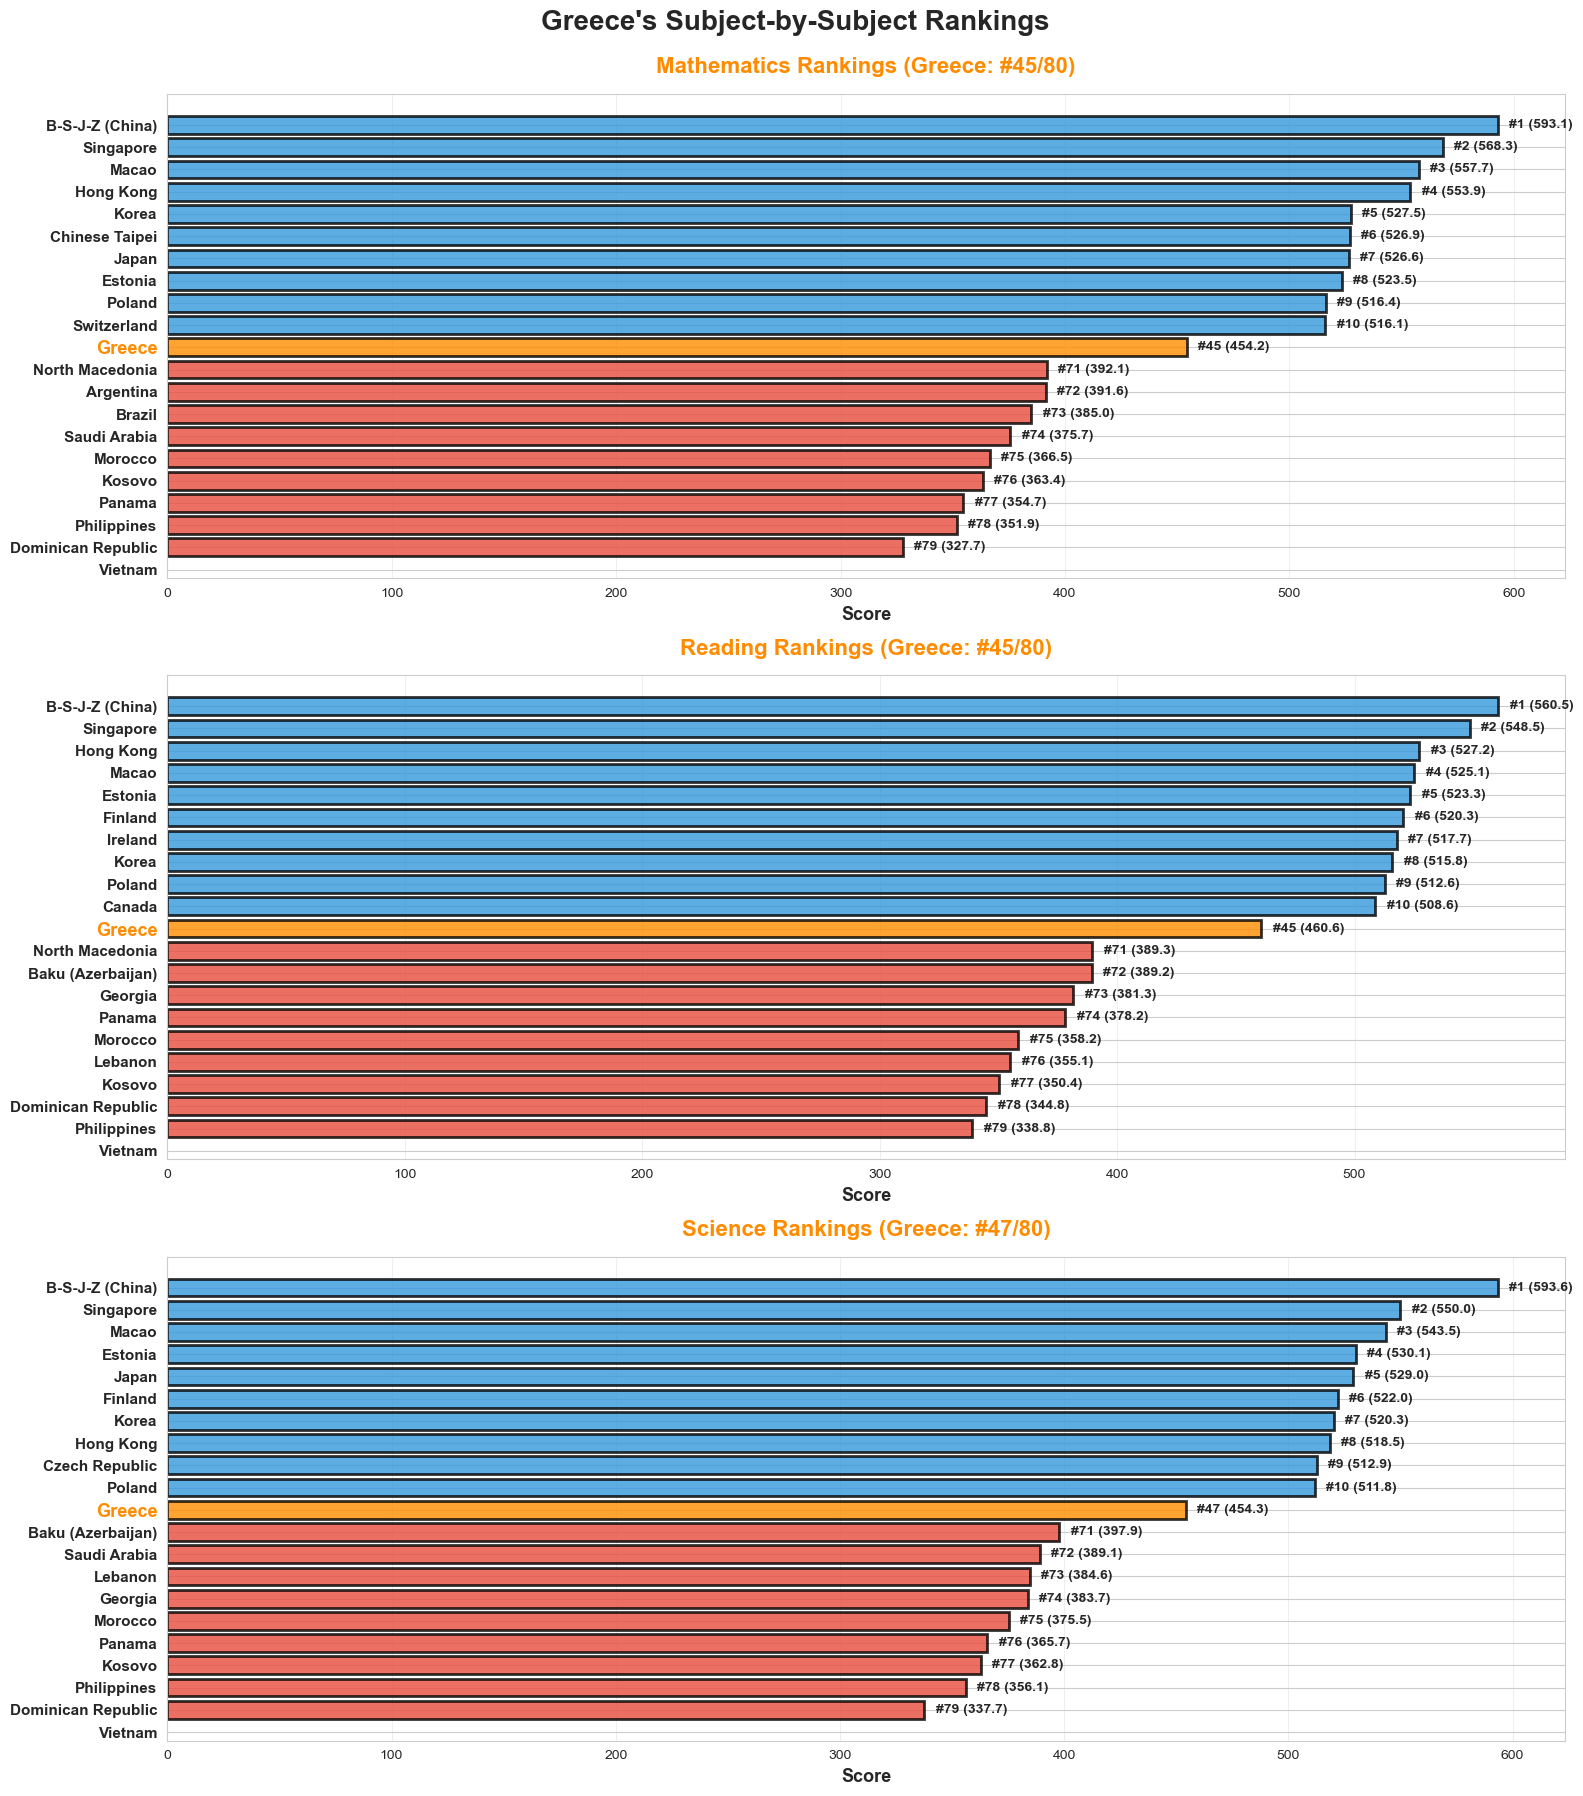

In [81]:
# Plot 10: Greece's Ranking Across Subjects
fig, axes = plt.subplots(3, 1, figsize=(16, 18))

subjects = [('Math', 'Mathematics'), ('Reading', 'Reading'), ('Science', 'Science')]

for ax, (col, title) in zip(axes, subjects):
    # Get rankings for this subject
    subject_ranking = country_scores[[col]].sort_values(col, ascending=False)
    subject_ranking['Rank'] = range(1, len(subject_ranking) + 1)
    
    # Get Greece's rank
    greece_rank = subject_ranking.loc['Greece', 'Rank']
    greece_score = subject_ranking.loc['Greece', col]
    
    # Plot top 10 + Greece + bottom 10
    top10 = subject_ranking.nsmallest(10, 'Rank')
    bottom10 = subject_ranking.nlargest(10, 'Rank')
    
    if 'Greece' not in top10.index and 'Greece' not in bottom10.index:
        plot_data = pd.concat([top10, subject_ranking.loc[['Greece']], bottom10])
    else:
        plot_data = pd.concat([top10, bottom10]).drop_duplicates()
    
    # Sort by rank
    plot_data = plot_data.sort_values('Rank')
    
    # Colors
    colors = []
    for country in plot_data.index:
        if country == 'Greece':
            colors.append('#FF8C00')
        elif country in top10.index:
            colors.append('#3498db')
        else:
            colors.append('#e74c3c')
    
    # Plot
    y_pos = range(len(plot_data))
    bars = ax.barh(y_pos, plot_data[col], color=colors, edgecolor='black', linewidth=2, alpha=0.8)
    
    # Labels
    ax.set_yticks(y_pos)
    ax.set_yticklabels(plot_data.index, fontsize=11, fontweight='bold')
    ax.set_xlabel('Score', fontsize=13, fontweight='bold')
    ax.set_title(f'{title} Rankings (Greece: #{int(greece_rank)}/{len(subject_ranking)})', 
                 fontsize=16, fontweight='bold', pad=15, color='#FF8C00')
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()
    
    # Add scores
    for i, (idx, row) in enumerate(plot_data.iterrows()):
        rank = int(row['Rank'])
        score = row[col]
        ax.text(score + 5, i, f"#{rank} ({score:.1f})", va='center', fontsize=10, fontweight='bold')
    
    # Color Greece label
    ytick_labels = ax.get_yticklabels()
    for label in ytick_labels:
        if label.get_text() == 'Greece':
            label.set_color('#FF8C00')
            label.set_fontsize(13)

fig.suptitle('Greece\'s Subject-by-Subject Rankings', fontsize=20, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('EDA_plots/plot_10_greece_subject_rankings.png', dpi=300, bbox_inches='tight')
plt.show()

## Interactive Visualizations

The following 2 interactive plots use Plotly for dynamic exploration of the data.

In [83]:
# Install plotly if not already installed
import sys
try:
    import plotly.graph_objects as go
    import plotly.express as px
    print("✓ Plotly already installed!")
except ImportError:
    print("Installing plotly...")
    import subprocess
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'plotly', '-q'])
    import plotly.graph_objects as go
    import plotly.express as px
    print("✓ Plotly installed successfully!")

✓ Plotly already installed!


In [84]:
# Interactive Plot 1: Country Performance Explorer
# Prepare data
plot_data = country_scores[['Math', 'Reading', 'Science', 'Overall']].reset_index()
plot_data.columns = ['Country', 'Mathematics', 'Reading', 'Science', 'Overall']
plot_data = plot_data.sort_values('Overall', ascending=False)

# Country groups
all_countries = plot_data['Country'].tolist()
top10_countries = plot_data.nlargest(10, 'Overall')['Country'].tolist()
top20_countries = plot_data.nlargest(20, 'Overall')['Country'].tolist()
top5_countries = plot_data.nlargest(5, 'Overall')['Country'].tolist()
greece_comparison = top5_countries + ['Greece'] if 'Greece' not in top5_countries else top5_countries

# Create figure with dropdown menus
fig = go.Figure()

# Add traces for all three subjects
subjects = ['Mathematics', 'Reading', 'Science']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for subject, color in zip(subjects, colors):
    fig.add_trace(go.Bar(
        x=plot_data['Country'],
        y=plot_data[subject],
        name=subject,
        marker=dict(color=color),
        hovertemplate='<b>%{x}</b><br>' + subject + ': %{y:.1f}<extra></extra>'
    ))

# Create dropdown menu for country selection
country_buttons = []

# All Countries button
country_buttons.append(
    dict(label='🌍 All Countries (80)', method='update',
         args=[{'x': [all_countries, all_countries, all_countries],
                'y': [plot_data['Mathematics'].tolist(), 
                      plot_data['Reading'].tolist(), 
                      plot_data['Science'].tolist()]}])
)

# Top 10 button
country_buttons.append(
    dict(label='🏆 Top 10', method='update',
         args=[{'x': [top10_countries, top10_countries, top10_countries],
                'y': [[plot_data[plot_data['Country']==c][s].values[0] for c in top10_countries] 
                      for s in subjects]}])
)

# Top 20 button
country_buttons.append(
    dict(label='⭐ Top 20', method='update',
         args=[{'x': [top20_countries, top20_countries, top20_countries],
                'y': [[plot_data[plot_data['Country']==c][s].values[0] for c in top20_countries] 
                      for s in subjects]}])
)

# Greece vs Top 5 button
country_buttons.append(
    dict(label='🇬🇷 Greece vs Top 5', method='update',
         args=[{'x': [greece_comparison, greece_comparison, greece_comparison],
                'y': [[plot_data[plot_data['Country']==c][s].values[0] for c in greece_comparison] 
                      for s in subjects]}])
)

# Update layout with dropdown positioning
fig.update_layout(
    title={
        'text': '<b>Interactive Country Explorer</b><br><sub>Select country group from dropdown above</sub>',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20}
    },
    xaxis_title='Country',
    yaxis_title='Score',
    barmode='group',
    height=650,
    margin=dict(t=120),
    hovermode='closest',
    showlegend=True,
    legend=dict(
        title=dict(text='<b>Subject</b>', font=dict(size=12)),
        orientation="v",
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99,
        bgcolor="rgba(255, 255, 255, 0.9)",
        bordercolor="Black",
        borderwidth=2,
        font=dict(size=11)
    ),
    xaxis={'categoryorder': 'total descending'},
    updatemenus=[
        dict(
            active=0,
            buttons=country_buttons,
            direction='down',
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.01,
            xanchor='left',
            y=1.15,
            yanchor='top',
            bgcolor='rgba(255, 255, 255, 0.95)',
            bordercolor='#2c3e50',
            borderwidth=2,
            font=dict(size=12, color='#2c3e50')
        )
    ]
)

fig.show()
print("\n✓ Interactive Plot 1: Country Performance Explorer")
print("   Filters: 🌍 All Countries | 🏆 Top 10 | ⭐ Top 20 | 🇬🇷 Greece vs Top 5")


✓ Interactive Plot 1: Country Performance Explorer
   Filters: 🌍 All Countries | 🏆 Top 10 | ⭐ Top 20 | 🇬🇷 Greece vs Top 5


In [85]:
# Interactive Plot 2: Gender Gap Analysis - Subject Selector
# Prepare comprehensive data for scatter plot
scatter_data = []

for country in df_clean['CNT'].unique():
    country_df = df_clean[df_clean['CNT'] == country]

    # Calculate overall score
    overall_score = country_scores.loc[country, 'Overall']
    n_students = len(country_df)

    # Get gender gaps for each subject
    math_gap = gender_gap.loc[country, 'Math_Gap']
    reading_gap = gender_gap.loc[country, 'Reading_Gap']
    science_gap = gender_gap.loc[country, 'Science_Gap']

    scatter_data.append({
        'Country': country,
        'Overall_Score': overall_score,
        'Math_Gap': math_gap,
        'Reading_Gap': reading_gap,
        'Science_Gap': science_gap,
        'N_Students': n_students,
        'Is_Greece': 'Greece' if country == 'Greece' else 'Other'
    })

scatter_df = pd.DataFrame(scatter_data)

# Create animated scatter plot using Plotly
fig2 = go.Figure()

# Add trace for each subject with animation buttons
subjects = [('Math_Gap', 'Mathematics', '#3498db'),
            ('Reading_Gap', 'Reading', '#e74c3c'),
            ('Science_Gap', 'Science', '#2ecc71')]

# Countries to label (Greece + top 5 performers)
countries_to_label = ['Greece', 'B-S-J-Z (China)', 'Singapore', 'Estonia', 'Finland', 'Japan']

for i, (gap_col, subject_name, color) in enumerate(subjects):
    # Create separate traces for Greece and other countries
    other_countries = scatter_df[scatter_df['Is_Greece'] == 'Other']
    greece_data = scatter_df[scatter_df['Is_Greece'] == 'Greece']

    # Other countries trace (bubbles only)
    fig2.add_trace(go.Scatter(
        x=other_countries['Overall_Score'],
        y=other_countries[gap_col],
        mode='markers',
        name='Countries',
        marker=dict(
            size=other_countries['N_Students'] / 100,
            color=color,
            opacity=0.5,
            line=dict(width=1, color='white'),
            sizemode='diameter',
            sizemin=5
        ),
        text=other_countries['Country'],
        hovertemplate='<b>%{text}</b><br>' +
                     'Overall Score: %{x:.1f}<br>' +
                     f'{subject_name} Gap: %{{y:.1f}}<br>' +
                     '<extra></extra>',
        visible=(i == 0),
        showlegend=True
    ))

    # Greece trace (highlighted star)
    fig2.add_trace(go.Scatter(
        x=greece_data['Overall_Score'],
        y=greece_data[gap_col],
        mode='markers',
        name='GREECE',
        marker=dict(
            size=greece_data['N_Students'] / 80,
            color=color,
            opacity=1.0,
            line=dict(width=4, color='#FFD700'),
            sizemode='diameter',
            symbol='star'
        ),
        text=greece_data['Country'],
        hovertemplate='<b>GREECE</b><br>' +
                     'Overall Score: %{x:.1f}<br>' +
                     f'{subject_name} Gap: %{{y:.1f}}<br>' +
                     '<extra></extra>',
        visible=(i == 0),
        showlegend=True
    ))

    # Add country labels for key countries (text annotations)
    labeled_countries = scatter_df[scatter_df['Country'].isin(countries_to_label)]
    fig2.add_trace(go.Scatter(
        x=labeled_countries['Overall_Score'],
        y=labeled_countries[gap_col],
        mode='text',
        name='Country Labels',
        text=labeled_countries['Country'],
        textposition='top center',
        textfont=dict(
            size=10,
            color='black',
            family='Arial Black'
        ),
        hoverinfo='skip',
        visible=(i == 0),
        showlegend=False
    ))

# Create buttons for subject selection
buttons = []
for i, (gap_col, subject_name, color) in enumerate(subjects):
    # Calculate which traces should be visible (3 traces per subject: countries + Greece + labels)
    visible_array = [False] * (len(subjects) * 3)
    visible_array[i * 3] = True      # Countries trace
    visible_array[i * 3 + 1] = True  # Greece trace
    visible_array[i * 3 + 2] = True  # Labels trace

    buttons.append(dict(
        label=f'{subject_name}',
        method='update',
        args=[
            {'visible': visible_array},
            {'title': f'<b>Gender Gap Analysis: {subject_name}</b><br>' +
                     '<sub>Select subject from dropdown | Gold star = Greece</sub>',
             'yaxis': {'title': f'{subject_name} Gender Gap (Boys - Girls)', 
                      'showgrid': True, 'gridcolor': 'rgba(128, 128, 128, 0.2)',
                      'zeroline': True, 'zerolinewidth': 3, 'zerolinecolor': 'black'}}
        ]
    ))

# Update layout - Dropdown positioned ABOVE the plot
fig2.update_layout(
    title={
        'text': '<b>Gender Gap Analysis: Mathematics</b><br>' +
               '<sub>Select subject from dropdown | Gold star = Greece</sub>',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 18}
    },
    xaxis={
        'title': 'Country Overall Score',
        'showgrid': True,
        'gridcolor': 'rgba(128, 128, 128, 0.2)',
        'range': [300, 600]
    },
    yaxis={
        'title': 'Mathematics Gender Gap (Boys - Girls)',
        'showgrid': True,
        'gridcolor': 'rgba(128, 128, 128, 0.2)',
        'zeroline': True,
        'zerolinewidth': 3,
        'zerolinecolor': 'black'
    },
    height=700,
    margin=dict(t=140),
    hovermode='closest',
    plot_bgcolor='rgba(250, 250, 250, 0.9)',
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor="rgba(255, 255, 255, 0.95)",
        bordercolor="Black",
        borderwidth=2
    ),
    updatemenus=[
        dict(
            active=0,
            buttons=buttons,
            direction='down',
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.01,
            xanchor='left',
            y=1.18,
            yanchor='top',
            bgcolor='rgba(255, 255, 255, 0.95)',
            bordercolor='#2c3e50',
            borderwidth=2,
            font=dict(size=12, color='#2c3e50')
        )
    ],
    annotations=[
        dict(
            text='<b>Positive Gap</b><br>(Boys score higher)',
            xref='paper', yref='paper',
            x=0.98, y=0.98,
            xanchor='right', yanchor='top',
            showarrow=False,
            font=dict(size=11, color='#3498db'),
            bgcolor='rgba(255, 255, 255, 0.9)',
            bordercolor='#3498db',
            borderwidth=2,
            borderpad=6
        ),
        dict(
            text='<b>Negative Gap</b><br>(Girls score higher)',
            xref='paper', yref='paper',
            x=0.98, y=0.02,
            xanchor='right', yanchor='bottom',
            showarrow=False,
            font=dict(size=11, color='#e74c3c'),
            bgcolor='rgba(255, 255, 255, 0.9)',
            bordercolor='#e74c3c',
            borderwidth=2,
            borderpad=6
        )
    ]
)

fig2.show()
print("\n✓ Interactive Plot 2: Gender Gap Scatter Plot")
print("   Switch between: Mathematics | Reading | Science")
print("   Bubble size = Number of students | Greece = Gold star")


✓ Interactive Plot 2: Gender Gap Scatter Plot
   Switch between: Mathematics | Reading | Science
   Bubble size = Number of students | Greece = Gold star
